# Explore datasets

There are two datasets:
- ed_visits.csv 
- yet_to_arrive.csv

See the data dictionaries for more information. 

The ed_visits database uses the following concepts:

- visit: a single visit to the ED which may end in admission or discharge
- prediction times: the times in the day at which predictions are to be made (eg 06:00, 09:30, 12:00, 15:30, 22:00)
- visit snapshots: snapshots of visits observed at the prediction times; a vist may have multiple visit snapshots



## Set up the notebook environment


In [1]:
# Reload functions every time
%load_ext autoreload 
%autoreload 2

In [2]:
from pathlib import Path
import sys
import json


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


PROJECT_ROOT = Path().home() 
USER_ROOT = Path().home() / 'work'

sys.path.append(str(USER_ROOT / 'patientflow' / 'patientflow'))
sys.path.append(str(USER_ROOT / 'patientflow' / 'functions'))
sys.path.append(str(USER_ROOT / 'ed-predictor' / 'functions'))


data_path = Path(USER_ROOT / 'ed-predictor' / 'data-raw')



## Load parameters

These are set in config.json. You can change these for your own purposes. But the times of day will need to match those in the provided dataset if you want to run this notebook successfully.

In [3]:
# Load the times of day
import yaml

config_path = Path(USER_ROOT / 'patientflow')

with open(config_path / 'config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
# Convert list of times of day at which predictions will be made (currently stored as lists) to list of tuples
prediction_times = [tuple(item) for item in config['prediction_times']]

# See the times of day at which predictions will be made
prediction_times

[(6, 0), (9, 30), (12, 0), (15, 30), (22, 0)]

## Load ED visits data

In [4]:
start_date = '20220101'
end_date = '20240301'

In [39]:
uclh = False

data_path = Path(USER_ROOT / 'ed-predictor' / 'data-raw')

if not uclh: 
    data_filename = 'visits_exc_beds_exc_minority_' + start_date + '_' + end_date + '.pickle'
    csv_filename = 'ed_visits.csv'
    yta_filename = 'yet_to_arrive_' + start_date + '_' + end_date + '.pickle'
    yta_csv_filename = 'yet_to_arrive.csv'

else: 
    data_filename = 'uclh_visits_exc_beds_inc_minority_' + start_date + '_' + end_date + '.pickle'
    csv_filename = 'uclh_visits.csv'
    yta_filename = 'uclh_yet_to_arrive_' + start_date + '_' + end_date + '.pickle'
    yta_csv_filename = 'uclh_yet_to_arrive.csv'



visits_path = data_path / data_filename
visits_csv_path = data_path / csv_filename
yta_path = data_path / yta_filename
yta_csv_path = data_path / yta_csv_filename

In [40]:
import pandas as pd
import pickle

# csv_filename = 'ed_visits.csv'
# data_path = Path(USER_ROOT / 'ed-predictor' / 'data-raw')
# full_path = data_path / csv_filename
# visits = pd.read_csv(full_path)

with open(visits_path, 'rb') as f:
    visits = pickle.load(f)

with open(yta_path, 'rb') as f:
    yta = pickle.load(f)

## Explore visits dataset

In [138]:
visits.columns

Index(['snapshot_date', 'prediction_time', 'visit_number', 'elapsed_los',
       'sex', 'age_group', 'arrival_method', 'current_location_type',
       'total_locations_visited', 'num_obs', 'num_obs_events', 'num_obs_types',
       'num_lab_batteries_ordered', 'has_consultation',
       'consultation_sequence', 'visited_majors', 'visited_otf',
       'visited_paeds', 'visited_rat', 'visited_resus', 'visited_sdec',
       'visited_sdec_waiting', 'visited_other', 'visited_utc',
       'visited_waiting', 'num_obs_pulse', 'num_obs_air_or_oxygen',
       'num_obs_level_of_consciousness',
       'num_obs_uclh_ed_manchester_triage_calculated_acuity',
       'num_obs_uclh_ed_manchester_triage_objective_pain_score',
       'num_obs_uclh_ed_manchester_triage_subjective_pain_score',
       'num_obs_temperature', 'num_obs_blood_pressure',
       'num_obs_glasgow_coma_scale_best_motor_response',
       'num_obs_news_score_result', 'num_obs_oxygen_delivery_method',
       'num_obs_oxygen_flow_rate', 

Note that each snapshot has a date and a prediction time formatted separately. 

In [26]:
visits.head(10)

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_hco3,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2030-04-09,"(12, 0)",1.0,780.0,F,45-54,Walk-in,waiting,2.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,121958,surgical
1,2030-04-09,"(15, 30)",1.0,13380.0,F,45-54,Walk-in,majors,5.0,30.0,...,141.0,6.84,7.371,5.28,NaN,train,[],False,146867,surgical
2,2030-08-03,"(12, 0)",3.0,4620.0,M,65-74,Walk-in,waiting,2.0,377.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,131932,medical
3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,None,sdec,4.0,400.0,...,136.0,5.41,7.371,14.10,NaN,train,[acute],True,103694,surgical
4,2030-04-24,"(12, 0)",5.0,4500.0,F,35-44,Walk-in,sdec_waiting,4.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[ambulatory],False,119879,surgical
5,2030-04-24,"(15, 30)",5.0,17100.0,F,35-44,Walk-in,sdec_waiting,4.0,24.0,...,137.0,NaN,NaN,7.03,NaN,train,[ambulatory],False,110268,surgical
6,2030-07-01,"(15, 30)",6.0,4500.0,F,25-34,Walk-in,rat,3.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,54886,medical
7,2030-04-08,"(15, 30)",9.0,1140.0,F,45-54,Walk-in,majors,4.0,26.0,...,NaN,NaN,NaN,5.55,NaN,train,[],False,137337,haem/onc
8,2030-04-08,"(22, 0)",9.0,24540.0,F,45-54,Walk-in,majors,6.0,70.0,...,140.0,NaN,NaN,4.57,23.0,train,[],False,168266,haem/onc


### Grouping of columns in visits dataset

As this is a large dataset, a function called get_dict_cols will organise the columns into groups

In [13]:
visits = visits.rename(columns = {
                                  'num_obs_uclh_ed_manchester_triage_subjective_pain_score' : 'num_obs_subjective_pain_score',
                                  'num_obs_uclh_ed_manchester_triage_objective_pain_score' : 'num_obs_objective_pain_score',
                                  'latest_obs_uclh_ed_manchester_triage_objective_pain_score' : 'latest_obs_objective_pain_score',
                                  'latest_obs_uclh_ed_manchester_triage_calculated_acuity' : 'latest_obs_manchester_triage_acuity',
                                  'num_obs_uclh_ed_manchester_triage_calculated_acuity' : 'num_obs_manchester_triage_acuity'
})
visits.loc[visits.latest_obs_objective_pain_score == 'Severe\E\Very Severe', 'latest_obs_objective_pain_score'] = 'Severe\Very Severe'


In [14]:
visits.columns

Index(['snapshot_date', 'prediction_time', 'visit_number', 'elapsed_los',
       'sex', 'age_group', 'arrival_method', 'current_location_type',
       'total_locations_visited', 'num_obs', 'num_obs_events', 'num_obs_types',
       'num_lab_batteries_ordered', 'has_consultation',
       'consultation_sequence', 'visited_majors', 'visited_otf',
       'visited_paeds', 'visited_rat', 'visited_resus', 'visited_sdec',
       'visited_sdec_waiting', 'visited_other', 'visited_utc',
       'visited_waiting', 'num_obs_pulse', 'num_obs_air_or_oxygen',
       'num_obs_level_of_consciousness', 'num_obs_manchester_triage_acuity',
       'num_obs_objective_pain_score', 'latest_obs_subjective_pain_score',
       'num_obs_temperature', 'num_obs_blood_pressure',
       'num_obs_glasgow_coma_scale_best_motor_response',
       'num_obs_news_score_result', 'num_obs_oxygen_delivery_method',
       'num_obs_oxygen_flow_rate', 'num_obs_pupil_reaction_right',
       'num_obs_uclh_sskin_areas_observed', 'lates

In [15]:
from data_dict_functions import get_dict_cols
dict_cols = get_dict_cols(visits)

for key, value in dict_cols.items():
    print(f"\nColumns in group called {key}:")
    print(value)




Columns in group called not used in training:
['snapshot_id', 'snapshot_date', 'prediction_time', 'visit_number', 'training_validation_test', 'random_number']

Columns in group called arrival and demographic:
['elapsed_los', 'sex', 'age_group', 'arrival_method']

Columns in group called summary:
['num_obs', 'num_obs_events', 'num_obs_types', 'num_lab_batteries_ordered']

Columns in group called location:
['current_location_type', 'total_locations_visited', 'visited_majors', 'visited_otf', 'visited_paeds', 'visited_rat', 'visited_resus', 'visited_sdec', 'visited_sdec_waiting', 'visited_other', 'visited_utc', 'visited_waiting']

Columns in group called observations:
['num_obs_pulse', 'num_obs_air_or_oxygen', 'num_obs_level_of_consciousness', 'num_obs_manchester_triage_acuity', 'num_obs_objective_pain_score', 'latest_obs_subjective_pain_score', 'num_obs_temperature', 'num_obs_blood_pressure', 'num_obs_glasgow_coma_scale_best_motor_response', 'num_obs_news_score_result', 'num_obs_oxygen_d

In [49]:
# Function to convert boolean columns to text values "true" or "false" - used for plotting format
def bool_to_text(df):
    bool_cols = df.select_dtypes(include='bool').columns.drop('is_admitted')
    for col in bool_cols:
        df[col] = df[col].apply(lambda x: 'true' if x else 'false')
    return df

# Apply the function
visits = bool_to_text(visits)
yta = bool_to_text(yta)

## Plot variables in datasets

Here we import a function called plot_distributions, which is saved in patientflow/functions. This function is not saved as part of the patientflow package, since people's preferences about plot formatting are very variable. You could edit this function or create your own. 


In [17]:
from plot_data import plot_distributions


### Arrival and demographic variables

#### Elapsed Length of Stay

Both admitted and not admitted visits appear to have a long tail of visits lasting more than 24 hours. Note that the data extraction that has created this dataset has not included any snapshots after 3 days. 


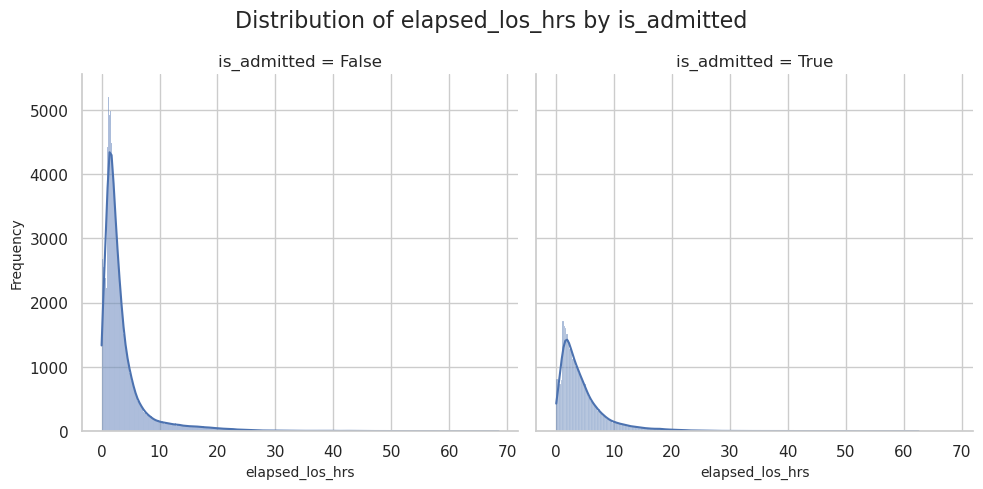

In [52]:
visits['elapsed_los_hrs'] = visits['elapsed_los']/3600
plot_distributions(visits, 'elapsed_los_hrs', 'is_admitted', plot_type='both')

Plotting only the visits of less than 24 hours, we can see a clear picture of activity aimed at getting people discharged within four hours

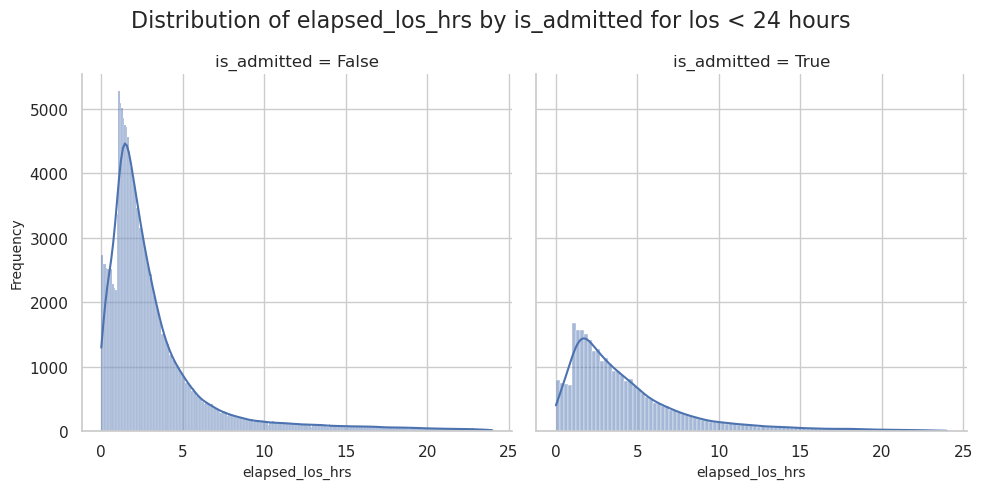

In [53]:
plot_distributions(visits[visits.elapsed_los_hrs < 24], 'elapsed_los_hrs', 'is_admitted', plot_type='both', title = 'Distribution of elapsed_los_hrs by is_admitted for los < 24 hours')

From below, we can see that the long tail of longer visits is more numerous for discharged than for admitted patients 

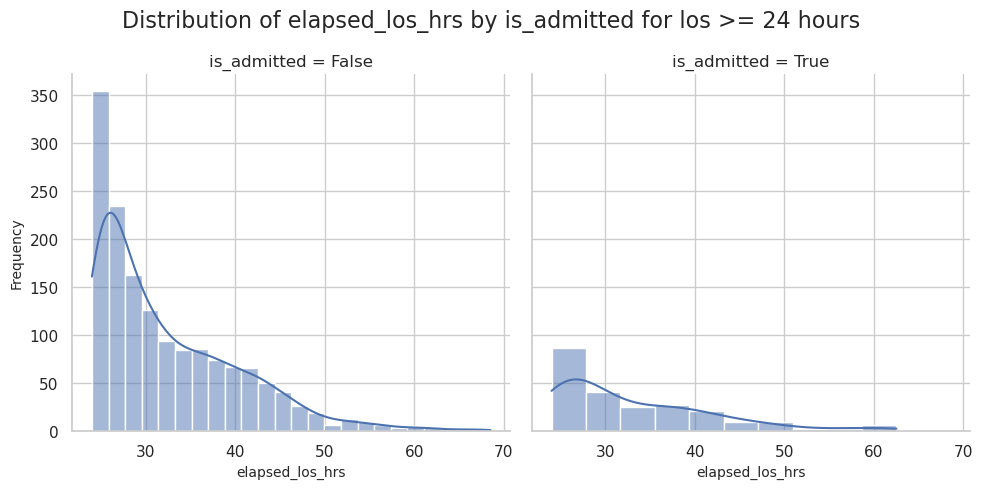

In [55]:
plot_distributions(visits[visits.elapsed_los_hrs >= 24], 'elapsed_los_hrs', 'is_admitted', plot_type='both', title = 'Distribution of elapsed_los_hrs by is_admitted for los >= 24 hours')

#### Sex, age group and arrival method

The charts below show a different distribution between admitted and not admitted patients for both age group (more older people are admitted) and arrival method (most walk-ins are discharged).

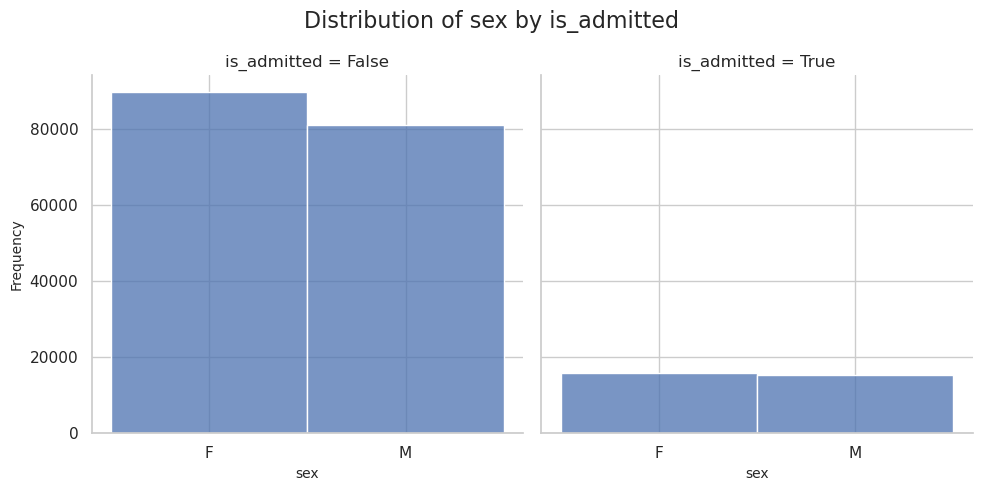

In [57]:
plot_distributions(visits, 'sex', 'is_admitted', plot_type='hist')

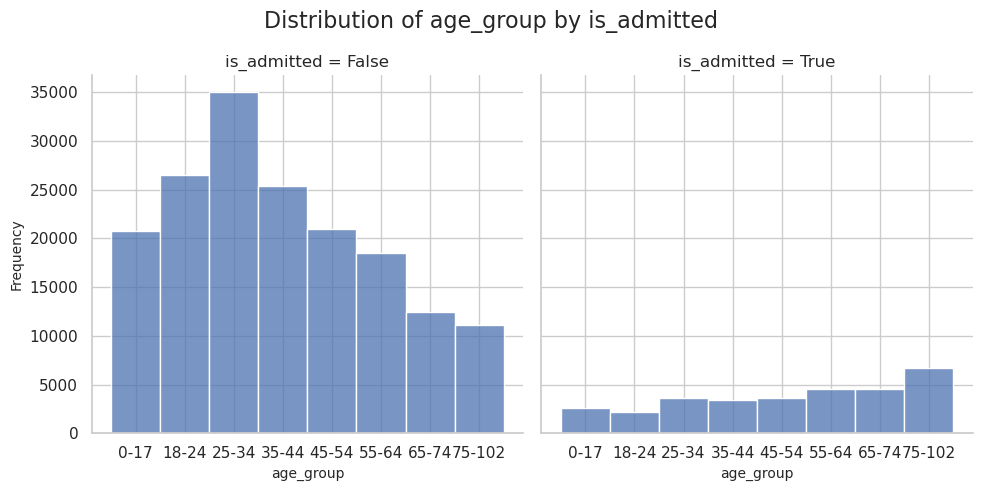

In [60]:
if 'age_group' in visits.columns:
    plot_distributions(visits, 'age_group', 'is_admitted', plot_type='hist')

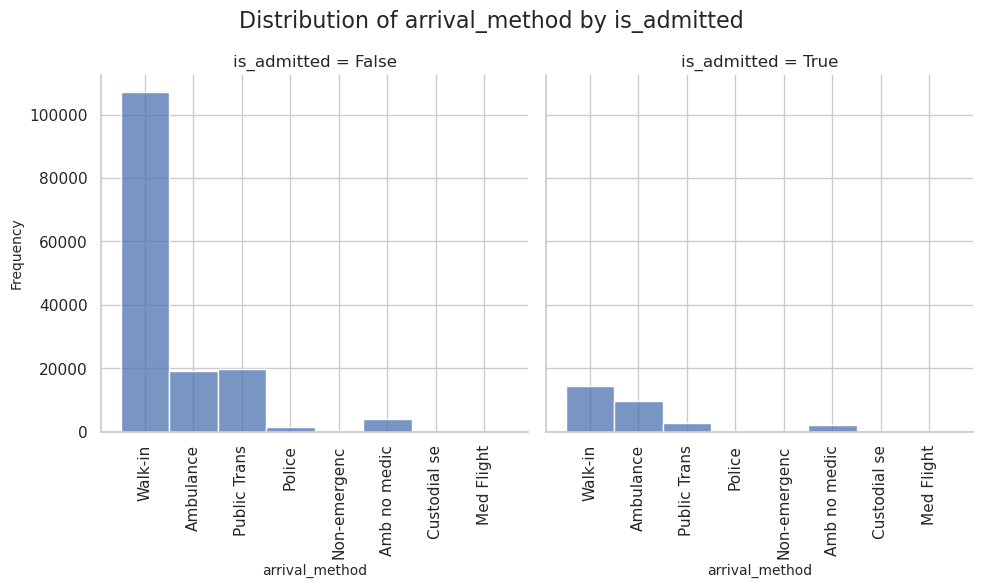

In [61]:
plot_distributions(visits, 'arrival_method', 'is_admitted', plot_type='hist', rotate_x_labels = True)

### Summary variables

The summary variables have counts of the following, up to the moment of the snapshot
* the number of observations recorded
* the number of events at which observations were recorded (if heart rate and respiratory rate have the same timestamp in the original data, this is one event)
* the number of different types of observations (heart rate and respiratory would be two types)
* the number of lab test batteries ordered

In [59]:
dict_cols['summary']

['num_obs', 'num_obs_events', 'num_obs_types', 'num_lab_batteries_ordered']

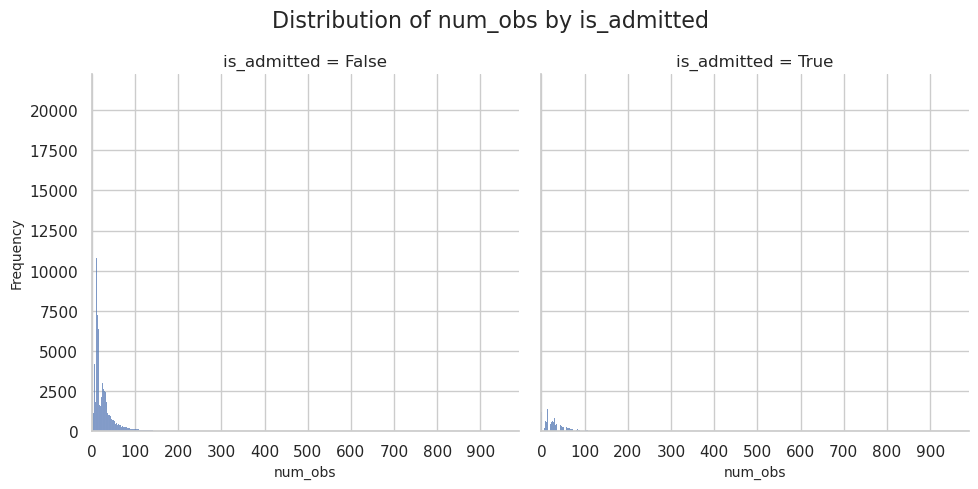

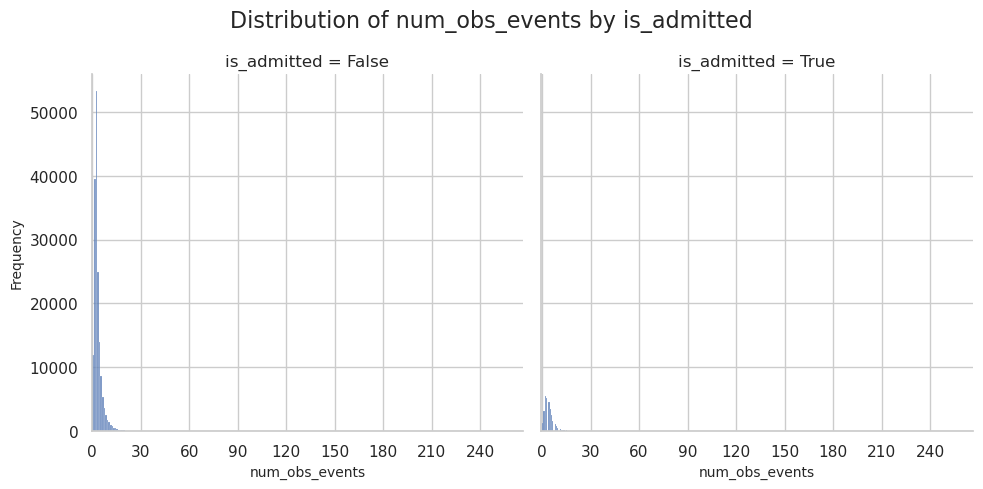

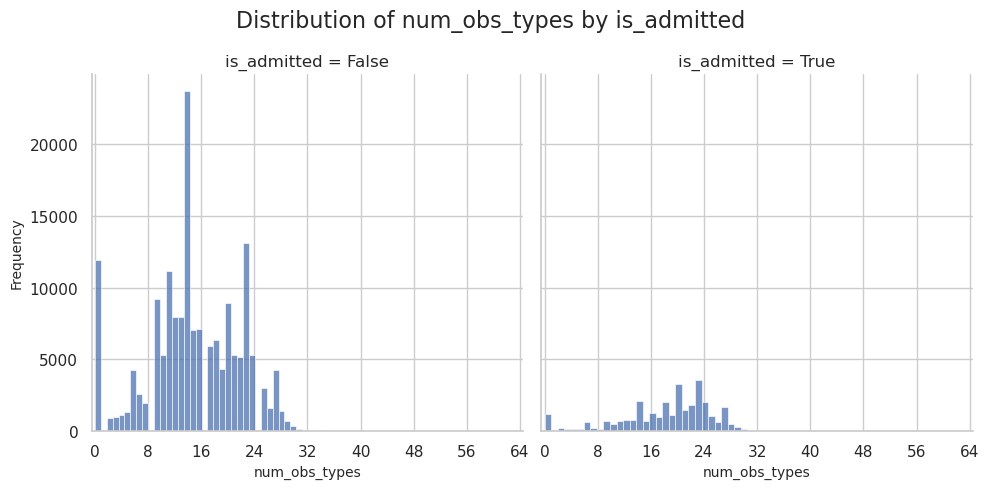

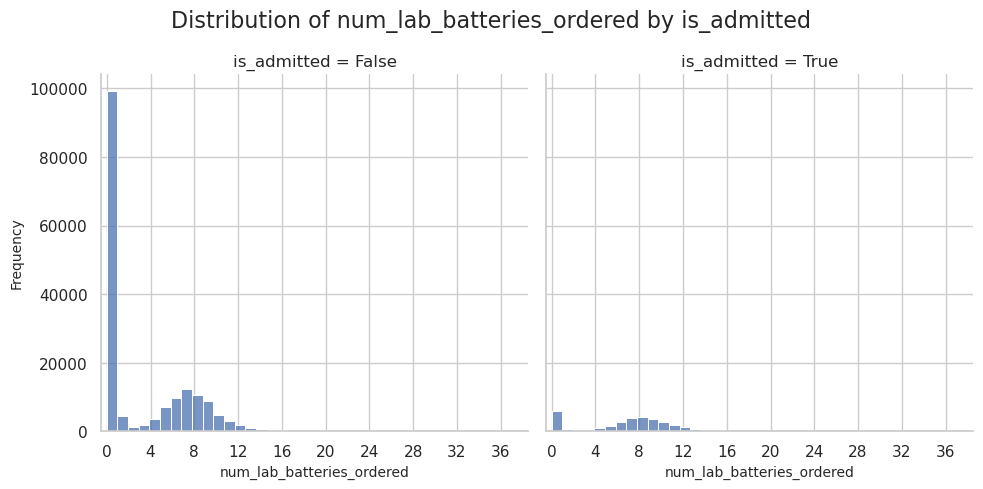

In [62]:
for col_name in dict_cols['summary']:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', is_discrete = True)

In [19]:
print(visits.num_obs.max())
print(visits.num_obs_events.max())

989.0
266.0


### Location variables

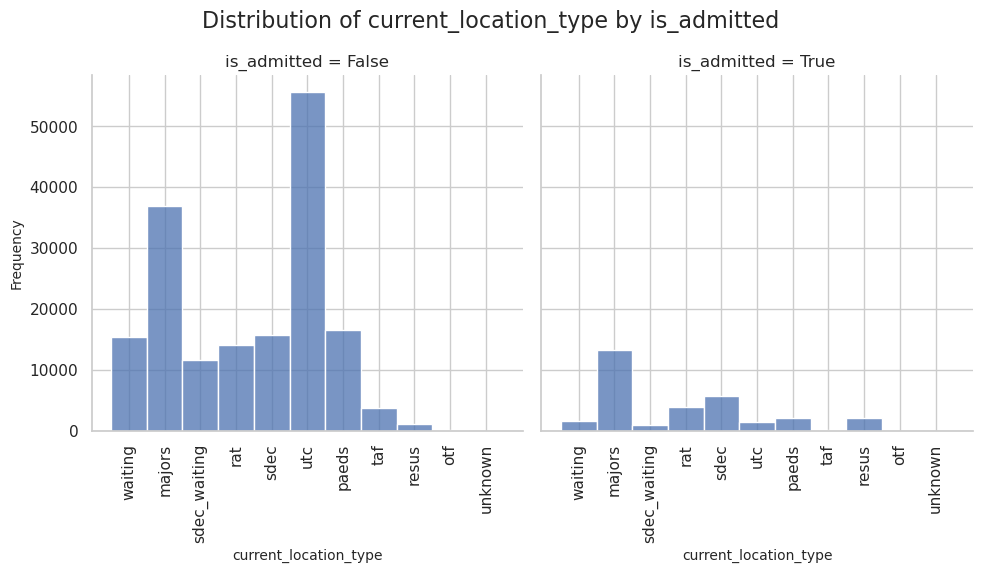

In [63]:
plot_distributions(visits, 'current_location_type', 'is_admitted', plot_type='hist', rotate_x_labels = True)

In [70]:
visits[~(visits.current_location_type == 'taf')]

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,latest_lab_results_hco3,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2030-04-09,"(12, 0)",1.0,780.0,F,45-54,Walk-in,waiting,2.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,121958,surgical
1,2030-04-09,"(15, 30)",1.0,13380.0,F,45-54,Walk-in,majors,5.0,30.0,...,141.0,6.84,7.371,5.28,NaN,train,[],False,146867,surgical
2,2030-08-03,"(12, 0)",3.0,4620.0,M,65-74,Walk-in,waiting,2.0,377.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,131932,medical
3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,None,sdec,4.0,400.0,...,136.0,5.41,7.371,14.10,NaN,train,[acute],True,103694,surgical
4,2030-04-24,"(12, 0)",5.0,4500.0,F,35-44,Walk-in,sdec_waiting,4.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[ambulatory],False,119879,surgical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201905,2030-12-07,"(6, 0)",196140.0,7569.0,M,18-24,Ambulance,majors,3.0,6.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,68376,NaN
201906,2030-05-22,"(6, 0)",196141.0,9541.0,M,0-17,Walk-in,paeds,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,train,[paeds],False,30061,NaN
201907,2030-05-22,"(6, 0)",196142.0,9445.0,F,0-17,Walk-in,paeds,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,126110,NaN


In [68]:
visits.current_location_type.value_counts()

current_location_type
utc             57059
majors          50140
sdec            21346
paeds           18688
rat             17951
waiting         17012
sdec_waiting    12568
taf              3749
resus            3249
otf               147
unknown             1
Name: count, dtype: int64

In [67]:
dict_cols['location']

['current_location_type',
 'total_locations_visited',
 'visited_majors',
 'visited_otf',
 'visited_paeds',
 'visited_rat',
 'visited_resus',
 'visited_sdec',
 'visited_sdec_waiting',
 'visited_other',
 'visited_utc',
 'visited_waiting']

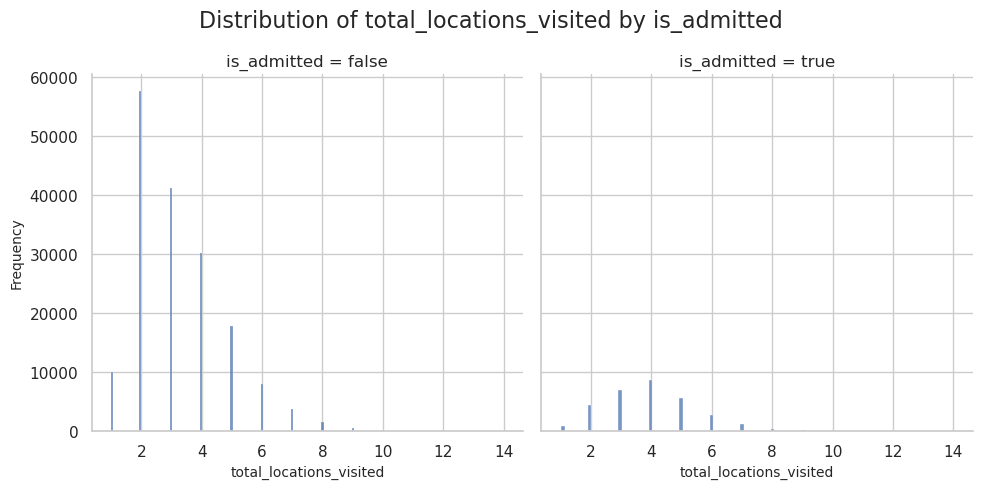

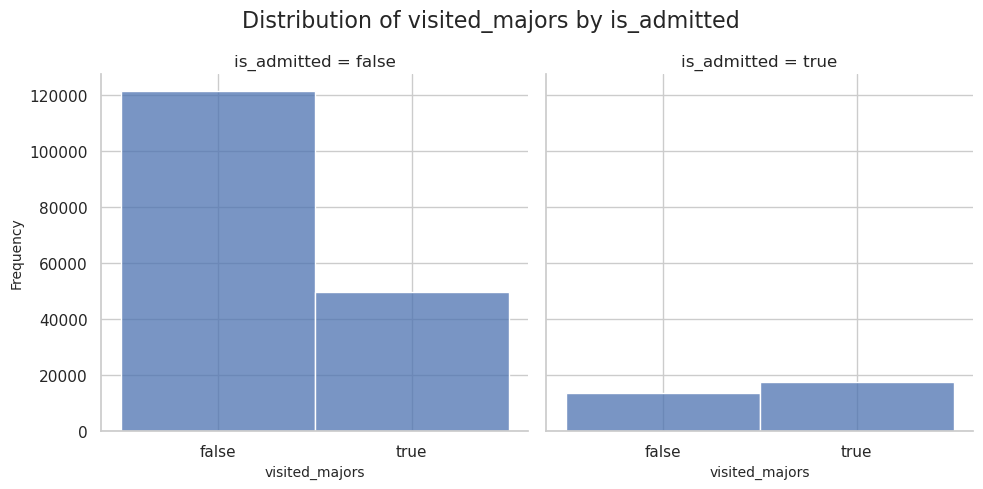

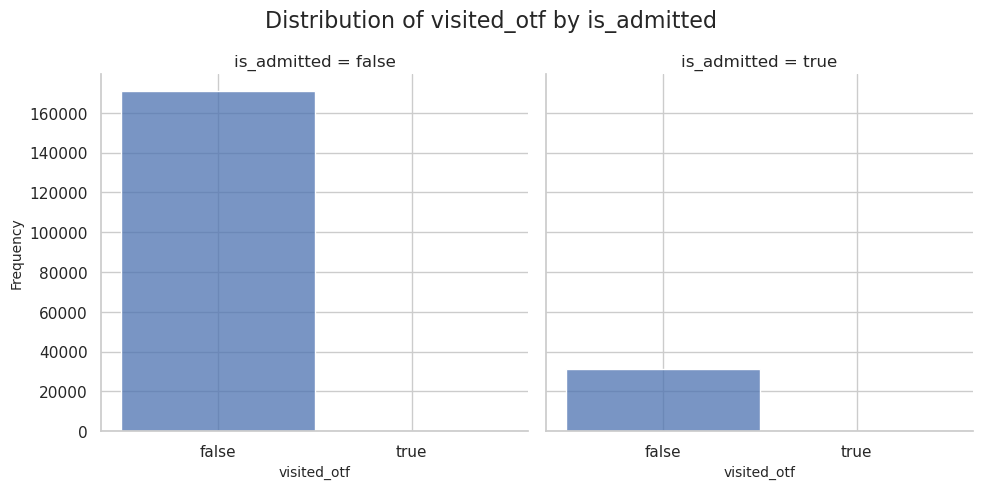

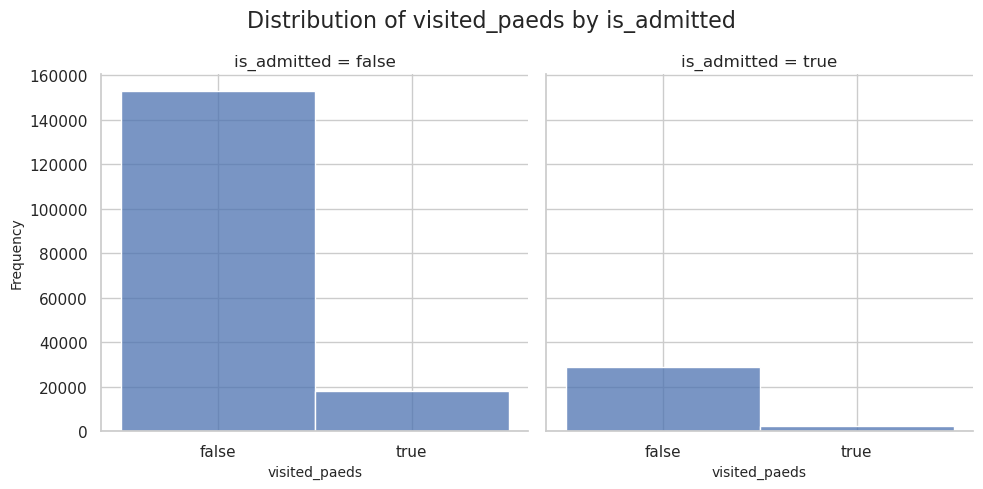

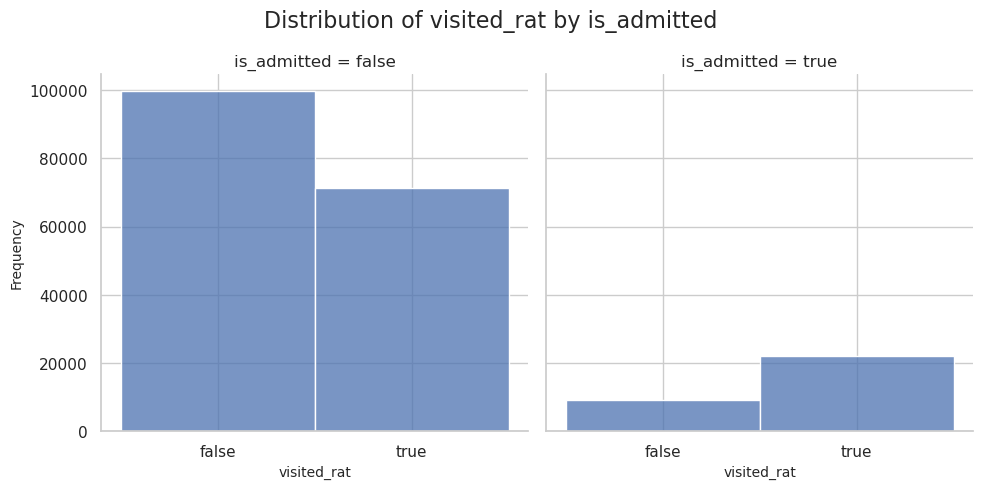

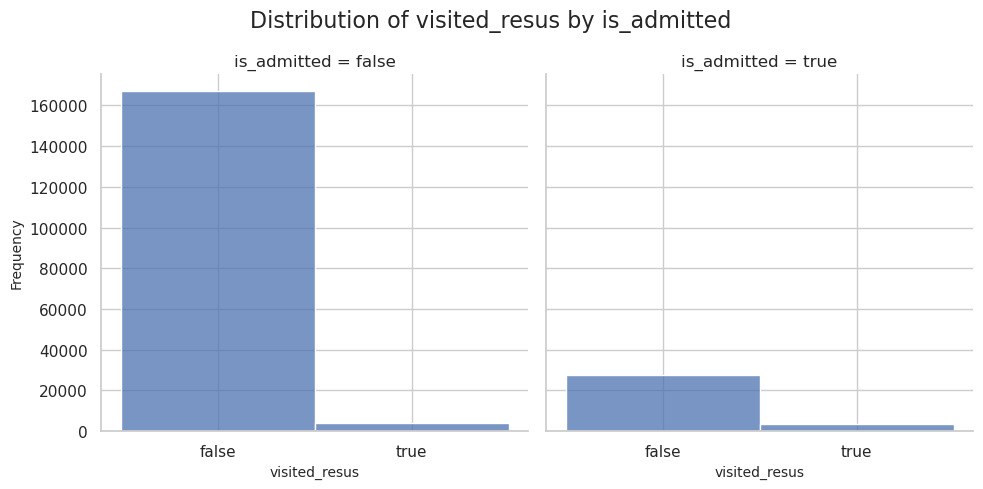

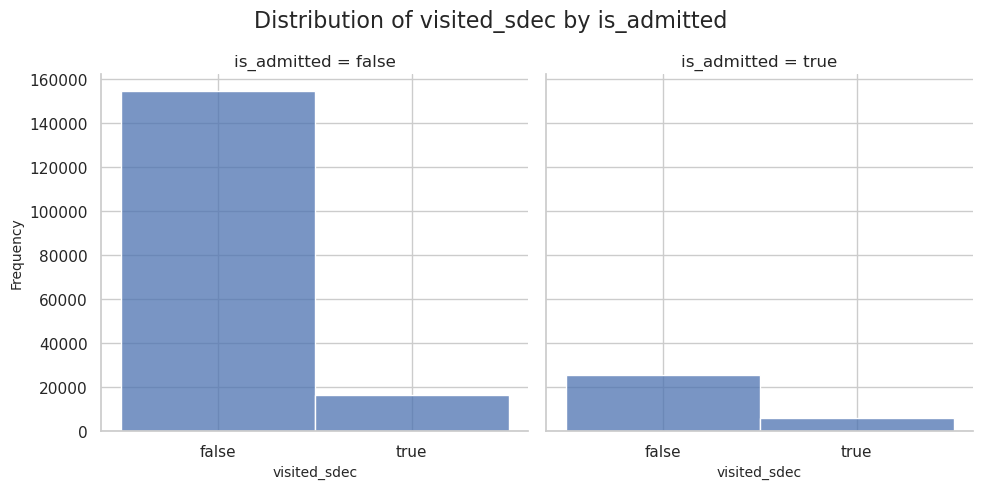

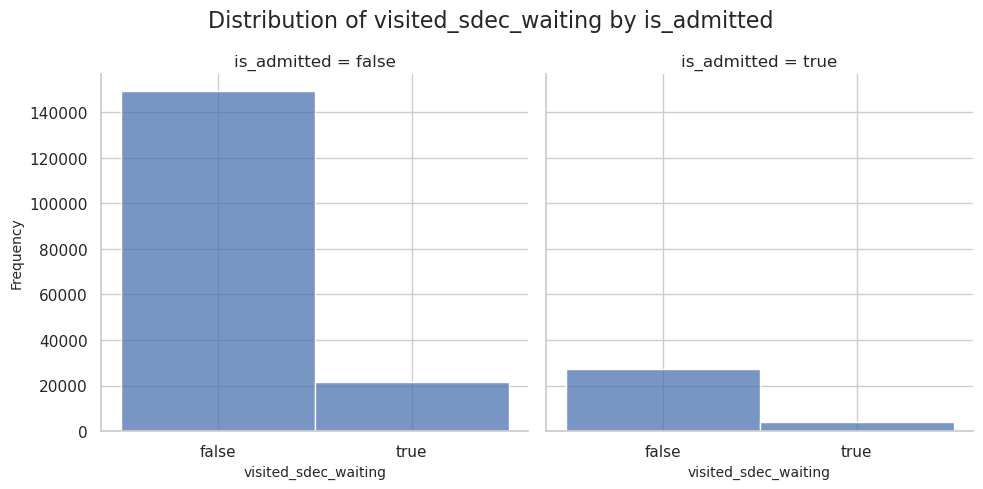

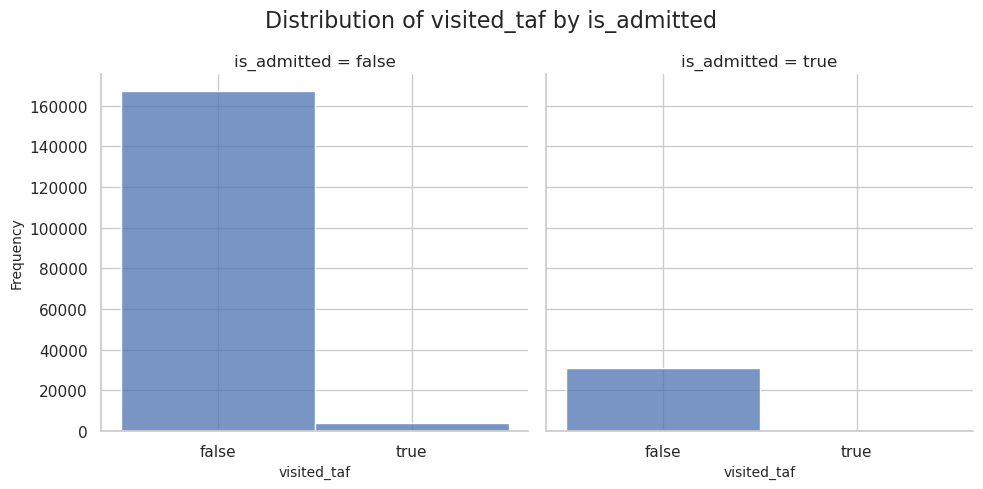

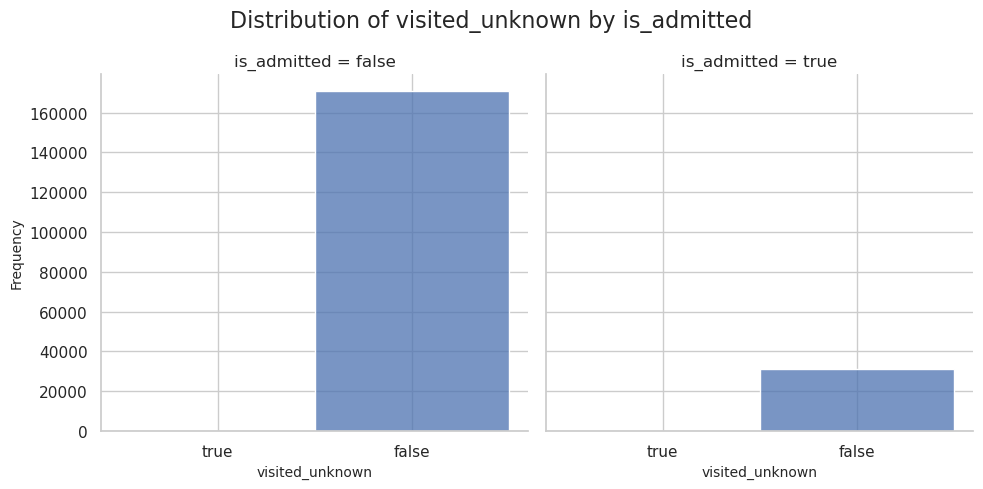

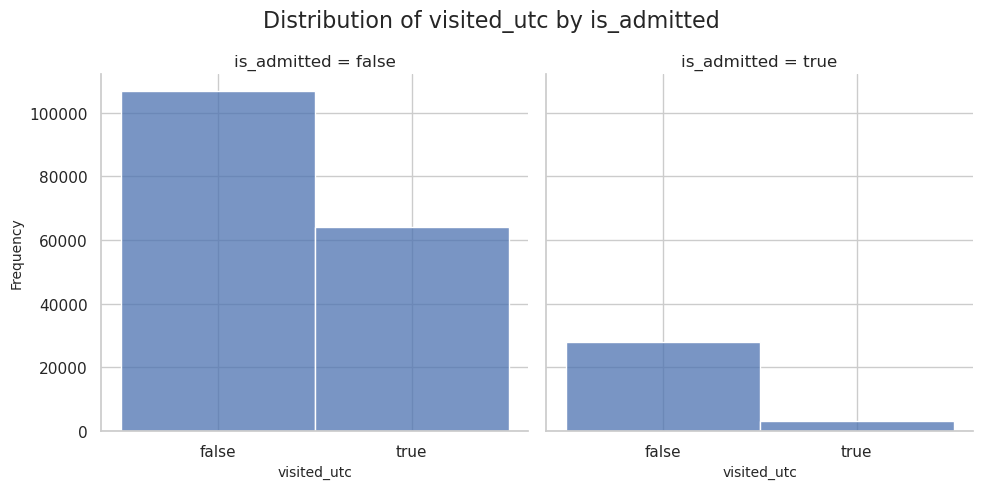

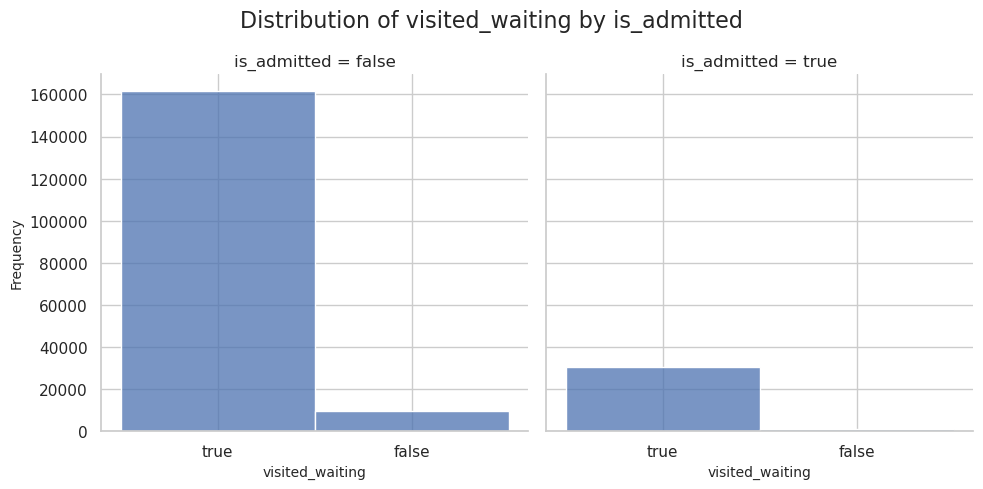

In [114]:
for col_name in dict_cols['location'][1:]:
    plot_distributions(df, col_name, 'is_admitted', plot_type='hist')

### Observations variables

In [110]:
dict_cols['observations']

['num_obs_pulse',
 'num_obs_air_or_oxygen',
 'num_obs_level_of_consciousness',
 'num_obs_uclh_ed_manchester_triage_calculated_acuity',
 'num_obs_uclh_ed_manchester_triage_objective_pain_score',
 'num_obs_uclh_ed_manchester_triage_subjective_pain_score',
 'num_obs_temperature',
 'num_obs_blood_pressure',
 'num_obs_glasgow_coma_scale_best_motor_response',
 'num_obs_news_score_result',
 'num_obs_oxygen_delivery_method',
 'num_obs_oxygen_flow_rate',
 'num_obs_pupil_reaction_right',
 'num_obs_uclh_sskin_areas_observed',
 'latest_obs_pulse',
 'latest_obs_respirations',
 'latest_obs_level_of_consciousness',
 'latest_obs_uclh_ed_manchester_triage_calculated_acuity',
 'latest_obs_uclh_ed_manchester_triage_objective_pain_score',
 'latest_obs_temperature',
 'latest_obs_news_score_result']

First plotting the variables that count the number of times something was recorded. 

#### Count variables

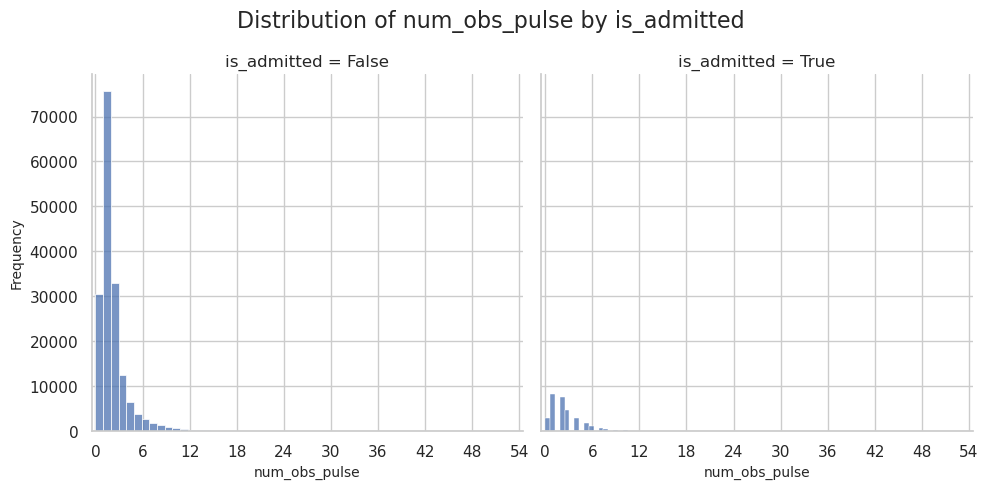

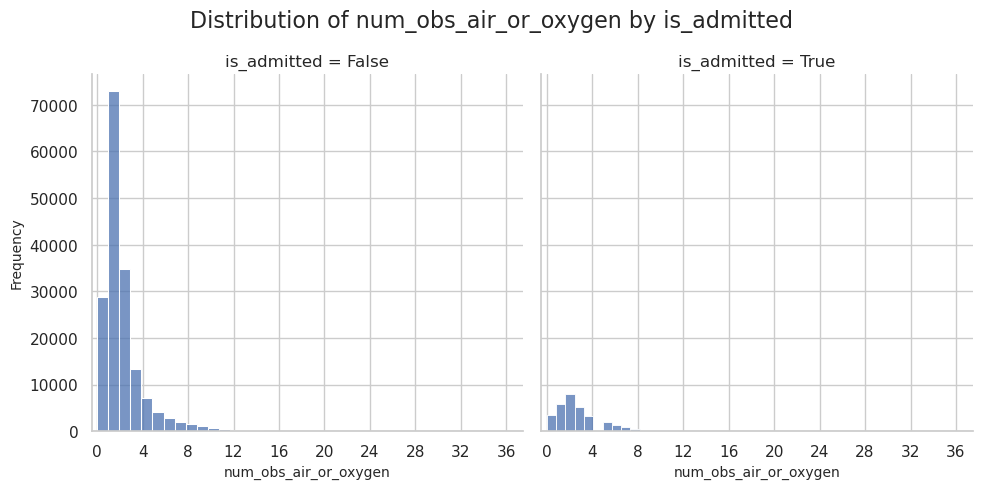

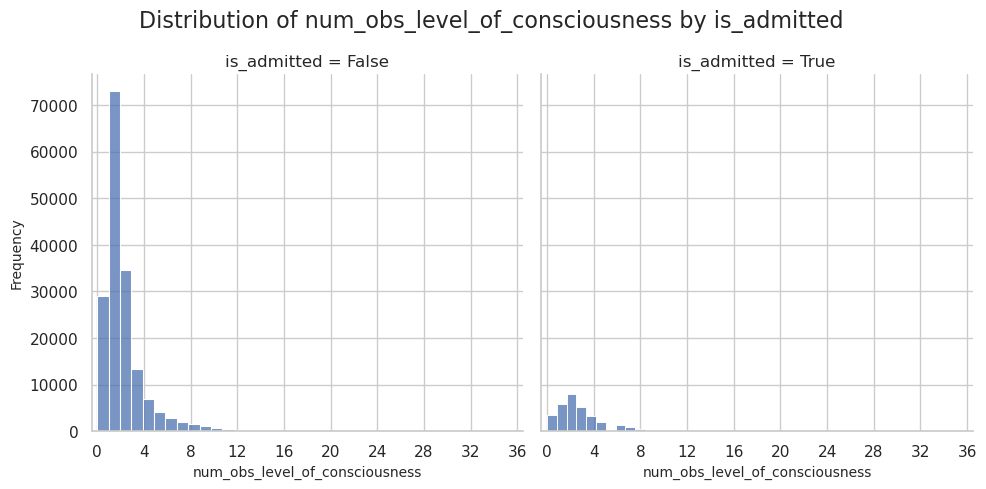

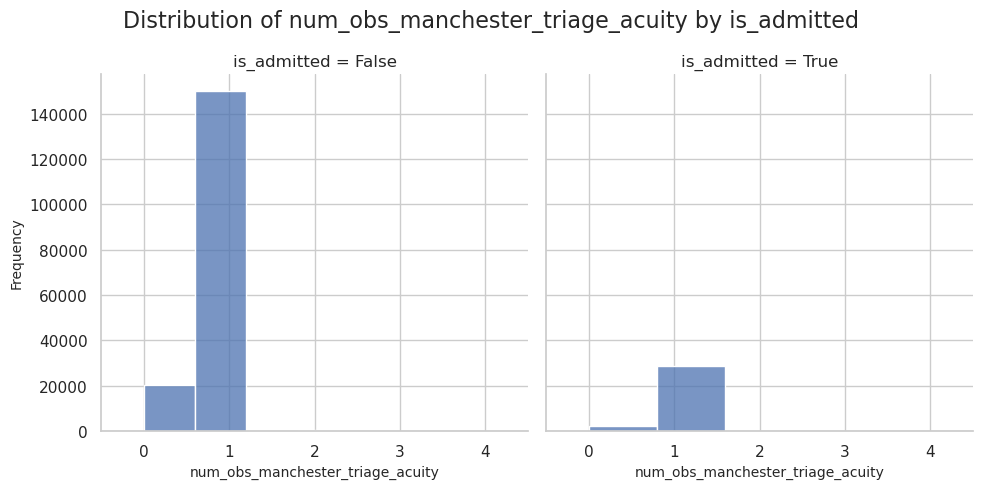

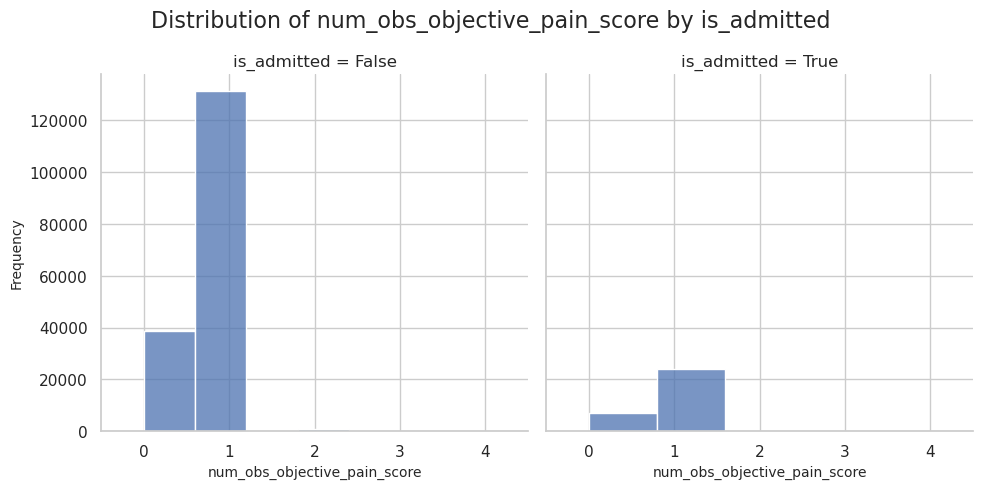

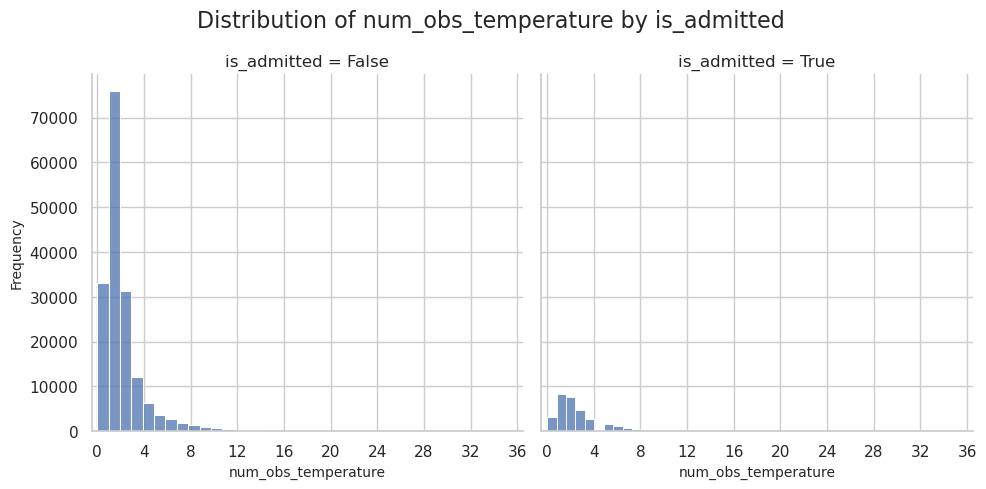

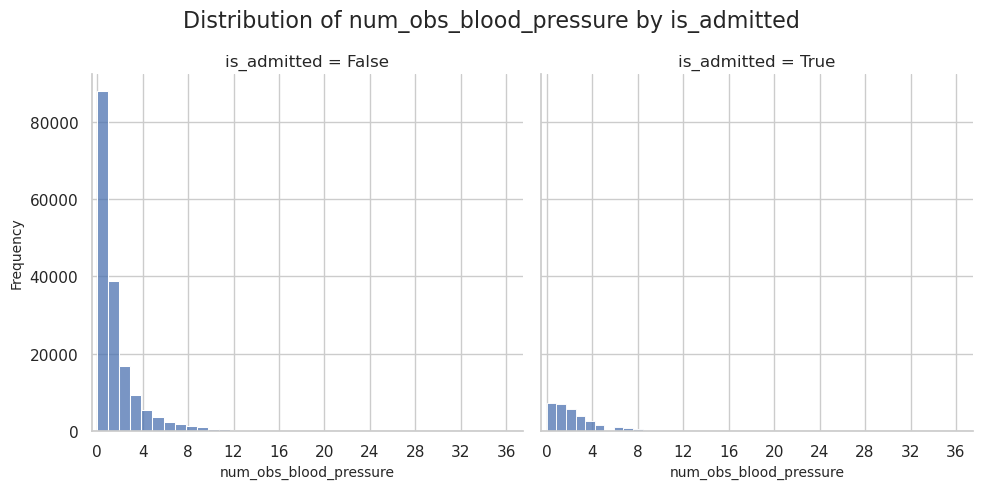

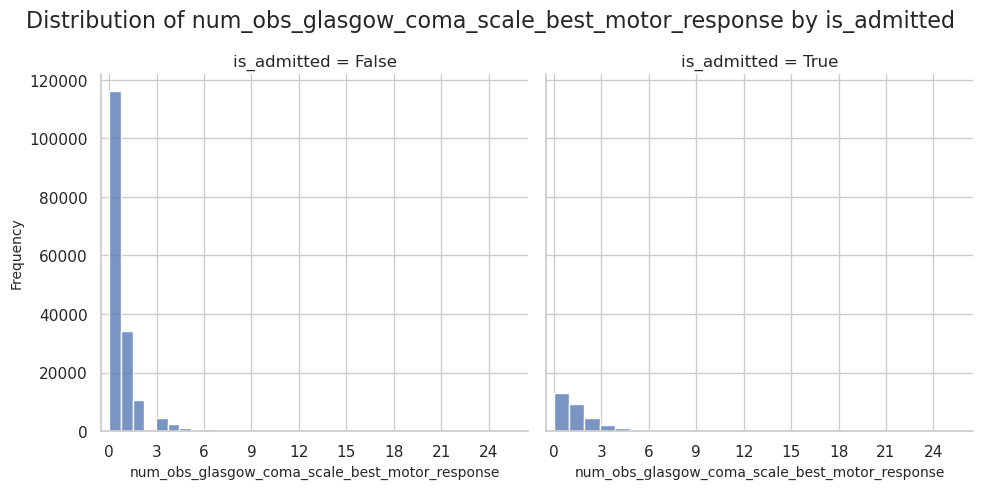

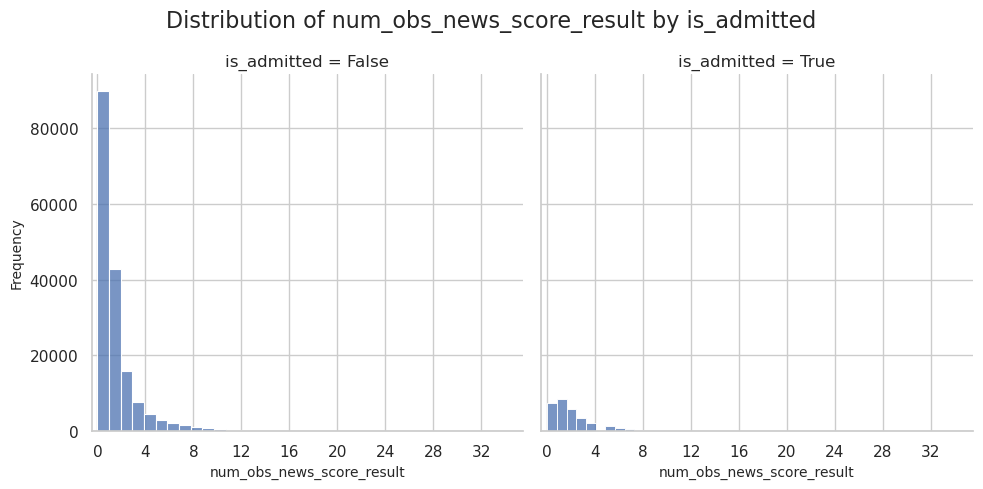

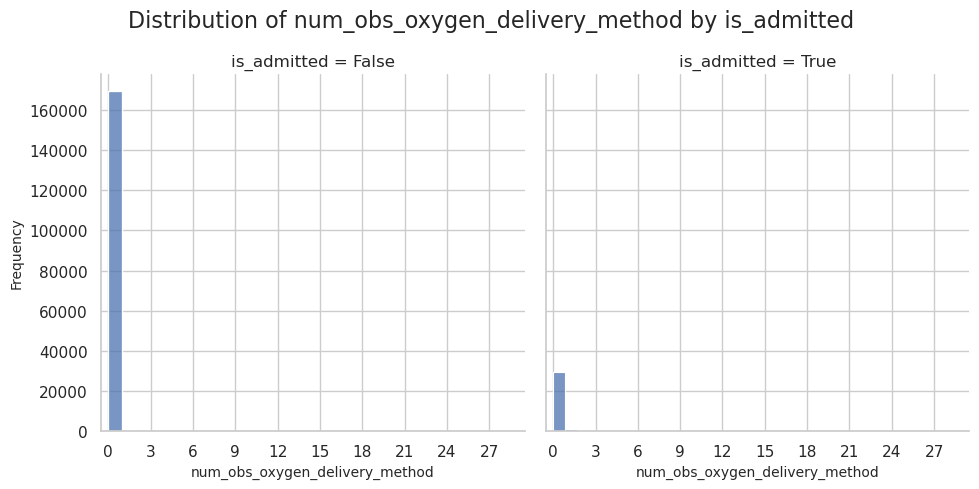

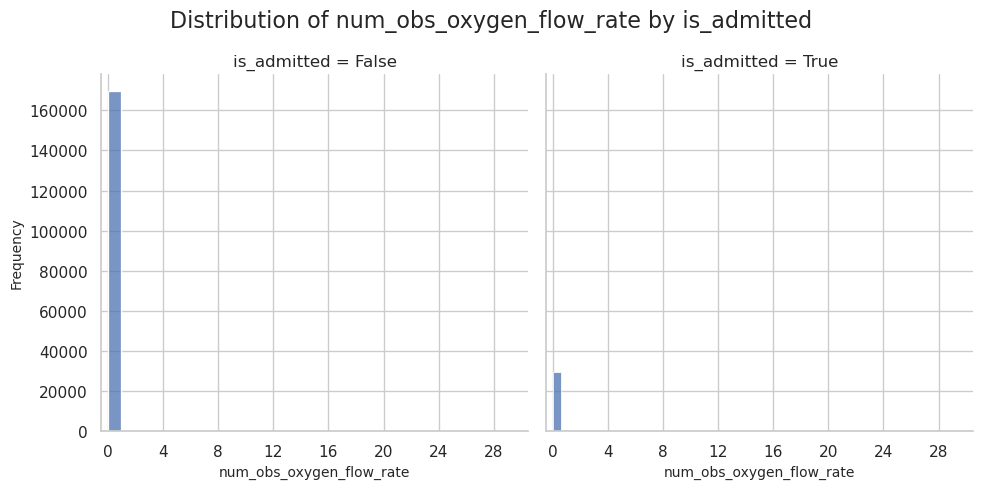

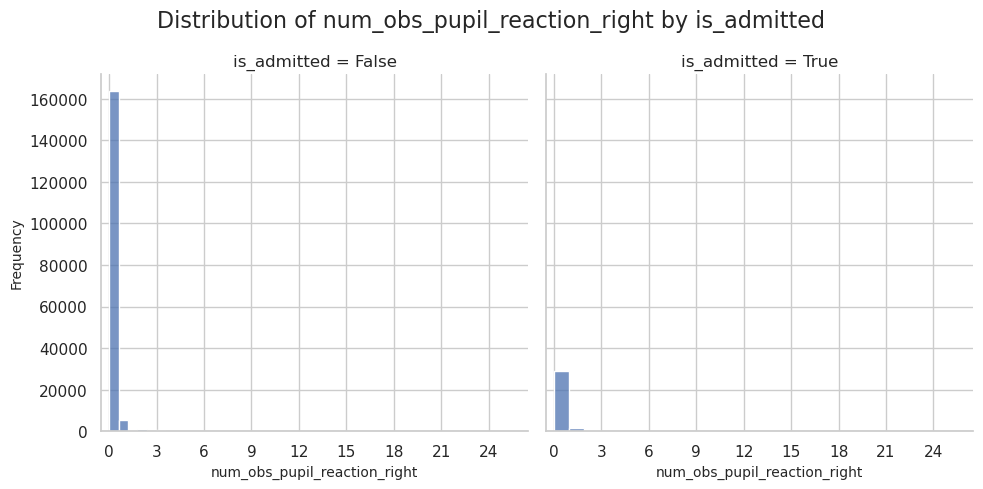

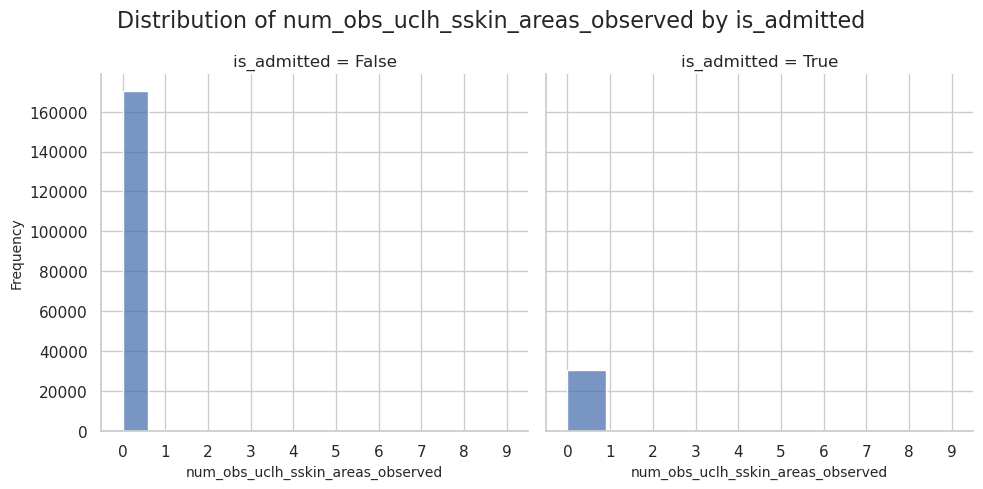

In [18]:
for col_name in [item for item in dict_cols['observations'] if str(item).startswith('num')]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', is_discrete = True)

Although the charts above are not formatted to show it, there are some higher values on some of these variables, for example:

In [78]:
visits.num_obs_uclh_sskin_areas_observed.value_counts()

num_obs_uclh_sskin_areas_observed
0.0    201066
1.0       691
2.0        80
3.0        42
4.0        19
6.0         5
5.0         4
8.0         1
7.0         1
9.0         1
Name: count, dtype: int64

#### News Scores and Manchester Triage score values

News Scores are commonly used to track the acuity of a patient, and Manchester Triage scores are used at the door of the ED to prioritise patients

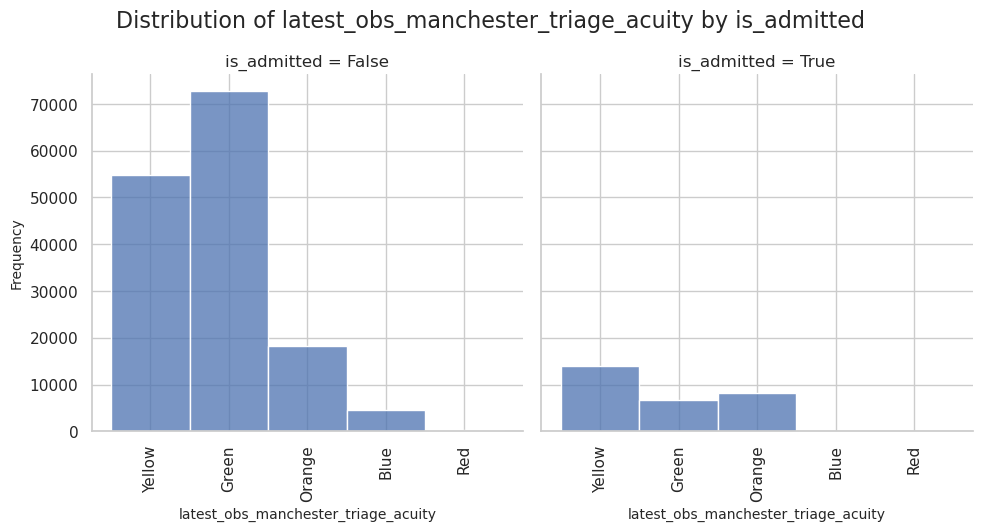

In [20]:
for col_name in [item for item in dict_cols['observations'] if ('manchester' in str(item) ) and str(item).startswith('latest')]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', rotate_x_labels = True)

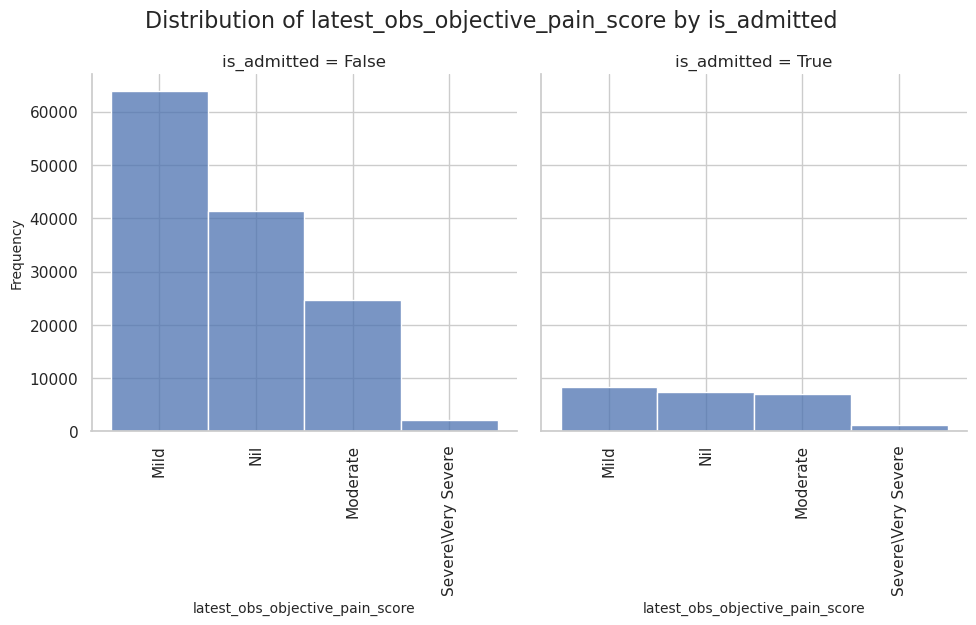

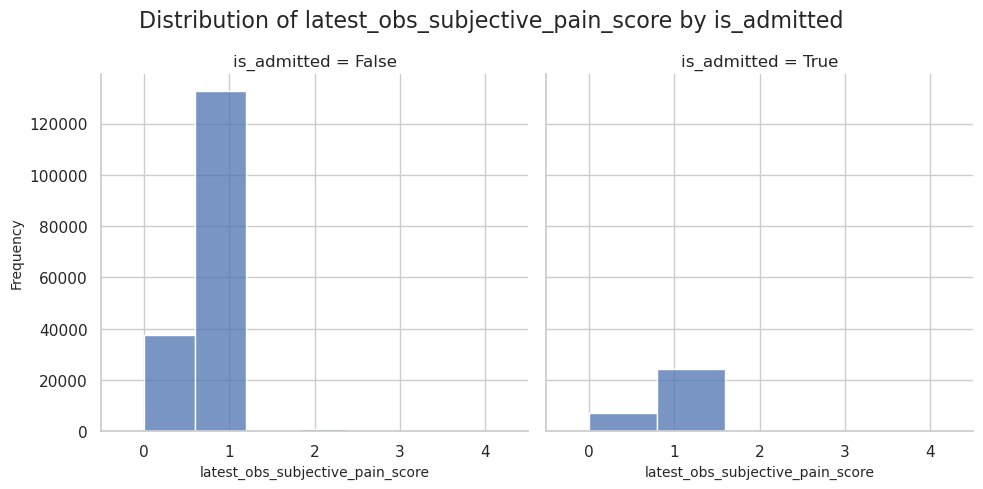

In [28]:


plot_distributions(visits, 'latest_obs_objective_pain_score', 'is_admitted', plot_type='hist', rotate_x_labels = True)
plot_distributions(visits, 'latest_obs_subjective_pain_score', 'is_admitted', plot_type='hist', is_discrete = True)

    

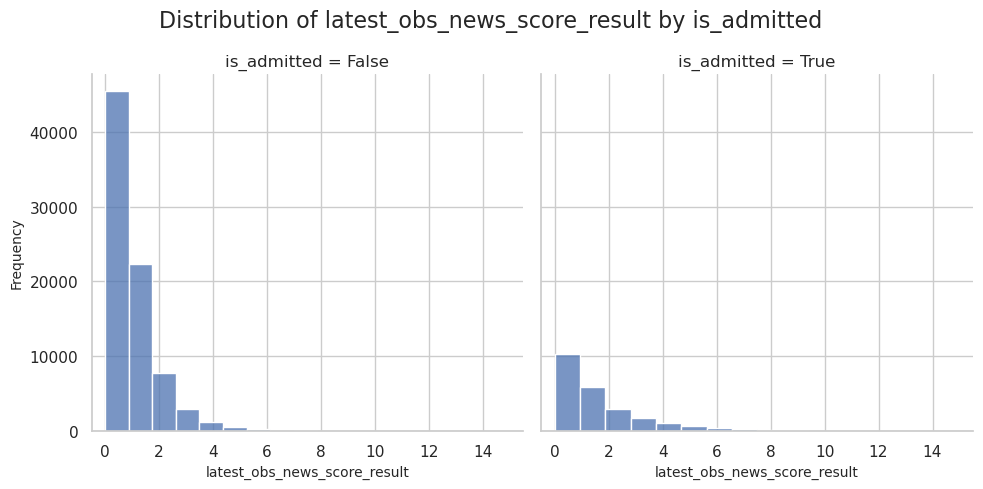

In [29]:
visits['latest_obs_news_score_result'] = visits.latest_obs_news_score_result.astype("float")

for col_name in [item for item in dict_cols['observations'] if 'news' in str(item) and str(item).startswith('latest')]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', is_discrete = True)

The ACVPU score is commonly used to track states of consciousness

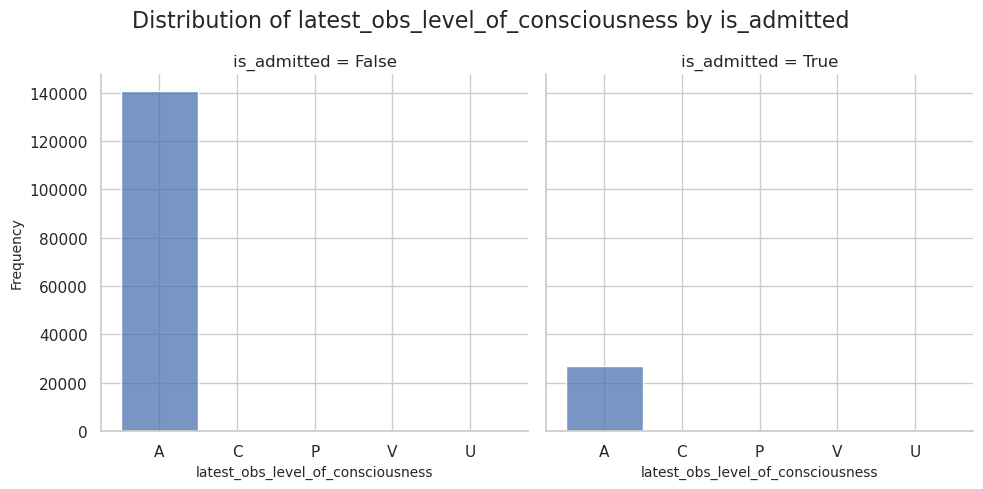

In [30]:
for col_name in [item for item in dict_cols['observations'] if 'consciousness' in str(item) and str(item).startswith('latest')]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist')

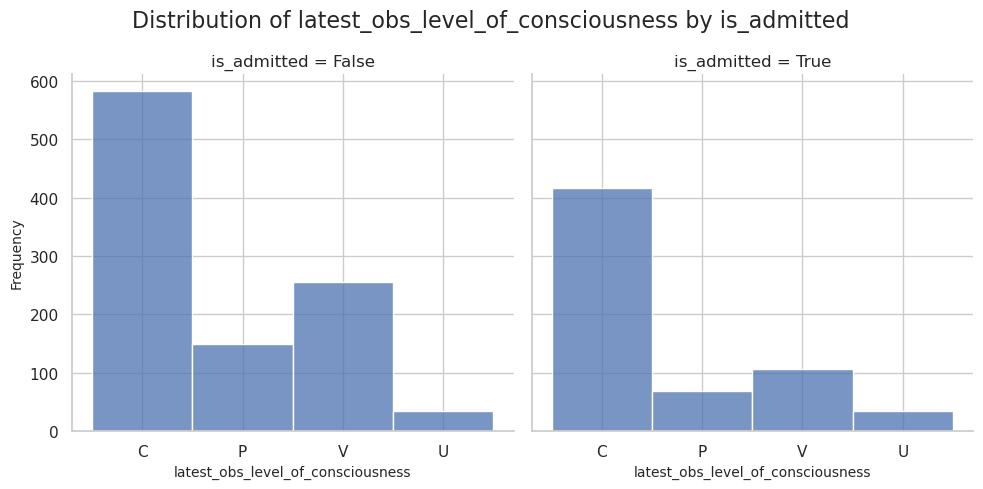

In [31]:
for col_name in [item for item in dict_cols['observations'] if 'consciousness' in str(item) and str(item).startswith('latest')]:
    plot_distributions(visits[~(visits.latest_obs_level_of_consciousness == 'A')], col_name, 'is_admitted', plot_type='hist')

#### Vital signs values

There are some outliers here that we may choose to omit

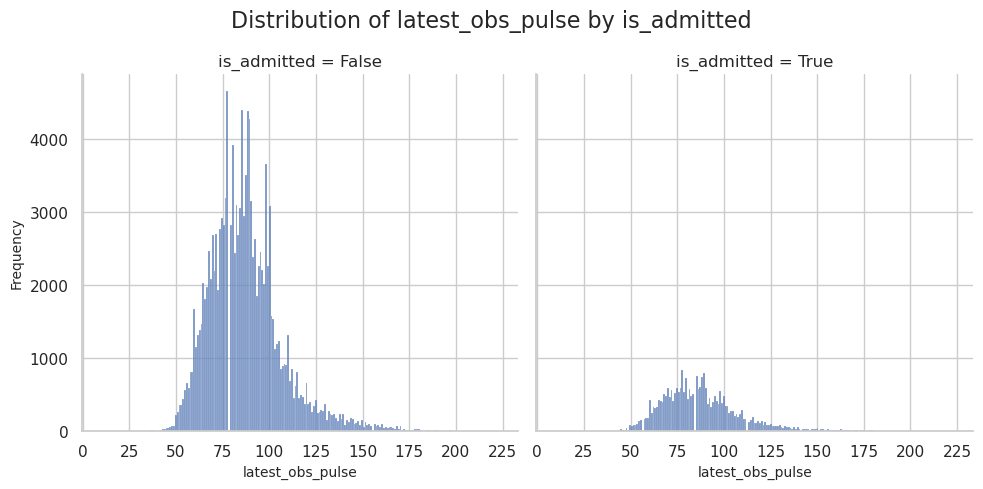

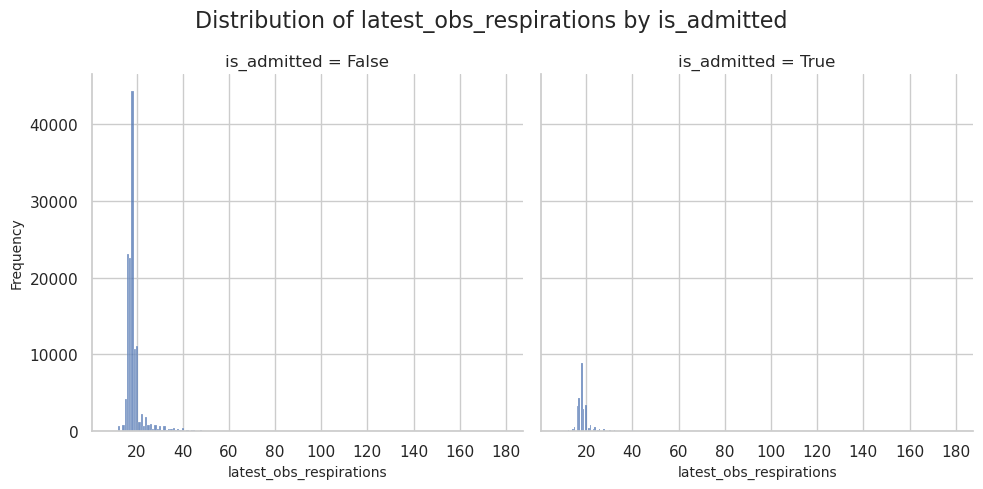

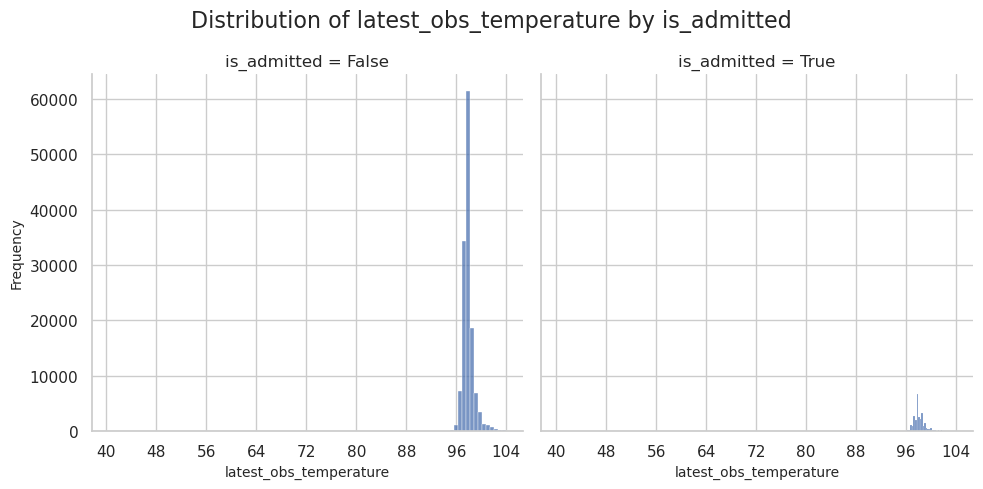

In [32]:
for col_name in [item for item in dict_cols['observations'] if str(item).startswith('latest') and ('pulse' in str(item) or 'resp' in str(item) or 'temp' in str(item))]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist', is_discrete = True)

### Lab variables

In [33]:
visits.drop(columns = 'latest_lab_results_hco3')

,snapshot_date,prediction_time,visit_number,elapsed_los,sex,age_group,arrival_method,current_location_type,total_locations_visited,num_obs,...,latest_lab_results_lac,latest_lab_results_na,latest_lab_results_pco2,latest_lab_results_ph,latest_lab_results_wcc,training_validation_test,final_sequence,is_admitted,random_number,specialty
snapshot_id,,,,,,,,,,,,,,,,,,,,,
0,2030-04-09,"(12, 0)",1.0,780.0,F,45-54,Walk-in,waiting,2.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,121958,surgical
1,2030-04-09,"(15, 30)",1.0,13380.0,F,45-54,Walk-in,majors,5.0,30.0,...,0.5,141.0,6.84,7.371,5.28,train,[],False,146867,surgical
2,2030-08-03,"(12, 0)",3.0,4620.0,M,65-74,Walk-in,waiting,2.0,377.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,131932,medical
3,2030-11-01,"(22, 0)",4.0,15600.0,F,75-102,None,sdec,4.0,400.0,...,1.2,136.0,5.41,7.371,14.10,train,[acute],True,103694,surgical
4,2030-04-24,"(12, 0)",5.0,4500.0,F,35-44,Walk-in,sdec_waiting,4.0,14.0,...,NaN,NaN,NaN,NaN,NaN,train,[ambulatory],False,119879,surgical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201905,2030-12-07,"(6, 0)",196140.0,7569.0,M,18-24,Ambulance,majors,3.0,6.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,68376,NaN
201906,2030-05-22,"(6, 0)",196141.0,9541.0,M,0-17,Walk-in,paeds,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,train,[paeds],False,30061,NaN
201907,2030-05-22,"(6, 0)",196142.0,9445.0,F,0-17,Walk-in,paeds,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,train,[],False,126110,NaN


In [117]:
dict_cols['lab orders and results']

['lab_orders_bc',
 'lab_orders_bon',
 'lab_orders_crp',
 'lab_orders_csnf',
 'lab_orders_ddit',
 'lab_orders_ncov',
 'lab_orders_rflu',
 'lab_orders_xcov',
 'latest_lab_results_alb',
 'latest_lab_results_crea',
 'latest_lab_results_hctu',
 'latest_lab_results_htrt',
 'latest_lab_results_k',
 'latest_lab_results_lac',
 'latest_lab_results_na',
 'latest_lab_results_pco2',
 'latest_lab_results_ph',
 'latest_lab_results_wcc',
 'latest_lab_results_hco3']

#### Lab orders

It is notable in the charts below, which show whether a lab battery was ordered, that battery CRP (for markers of inflammation) is very commonly ordered for admitted patients; in fact the majority of admitted patients have this lab battery order, whereas a minority of non-admitted patients do not. This difference between admitted and non-admitted (where the majority of admitted have something while the majority of discharged patients do not) only applies to this lab battery order. 

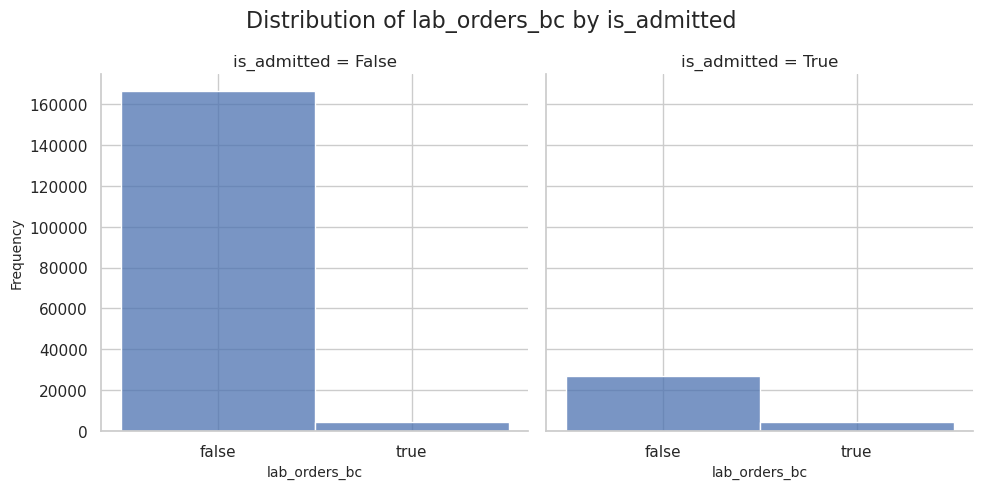

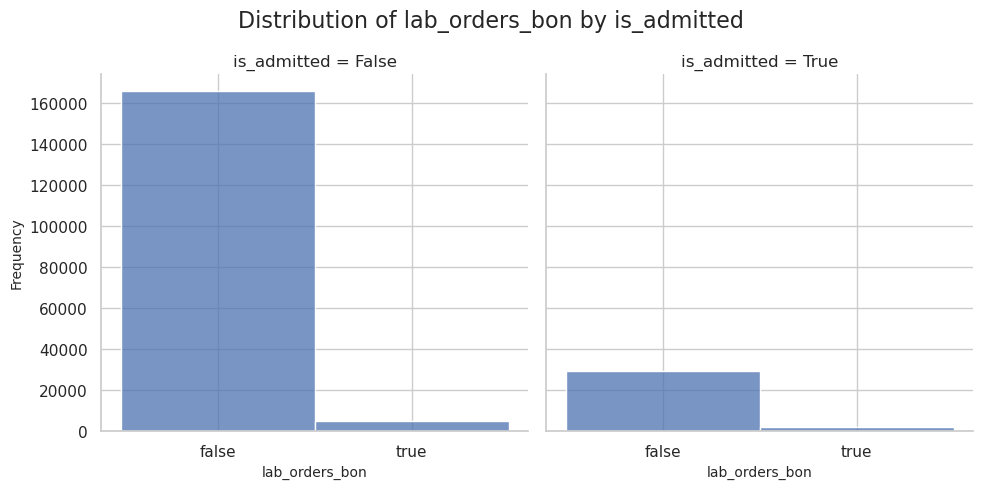

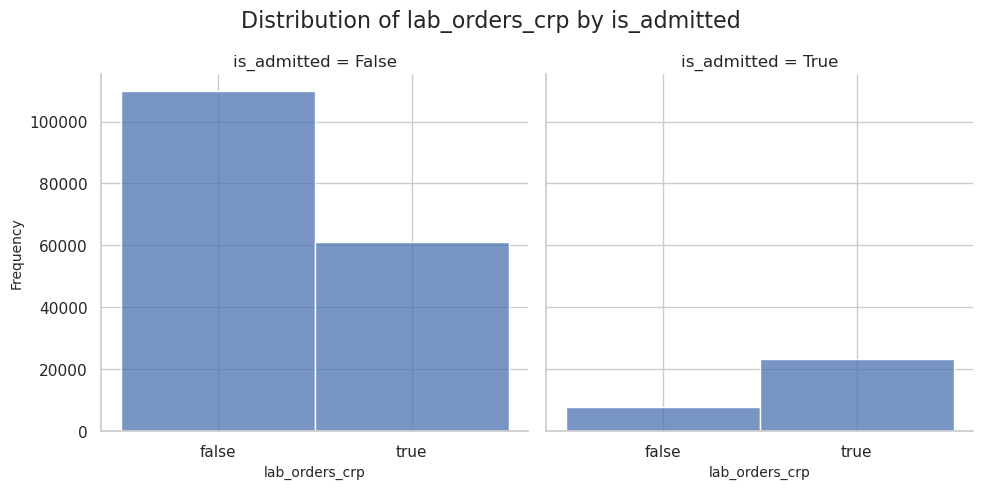

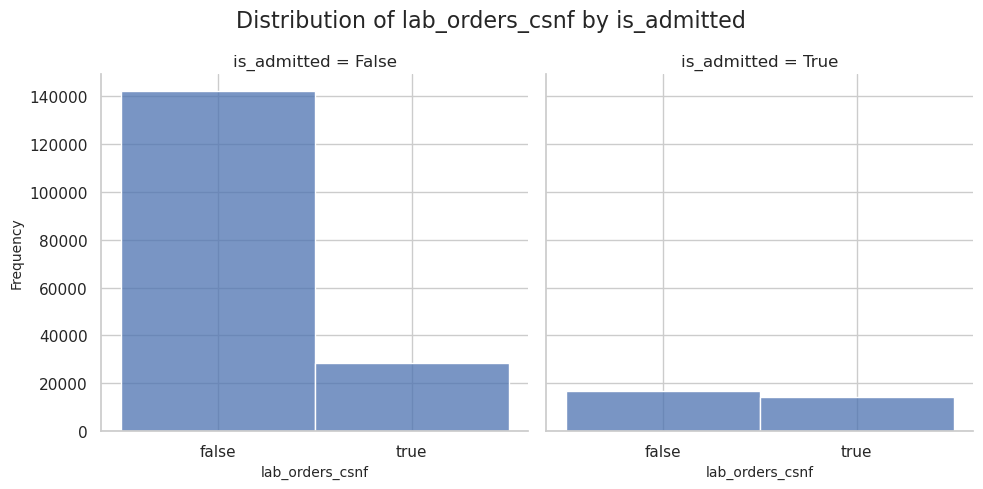

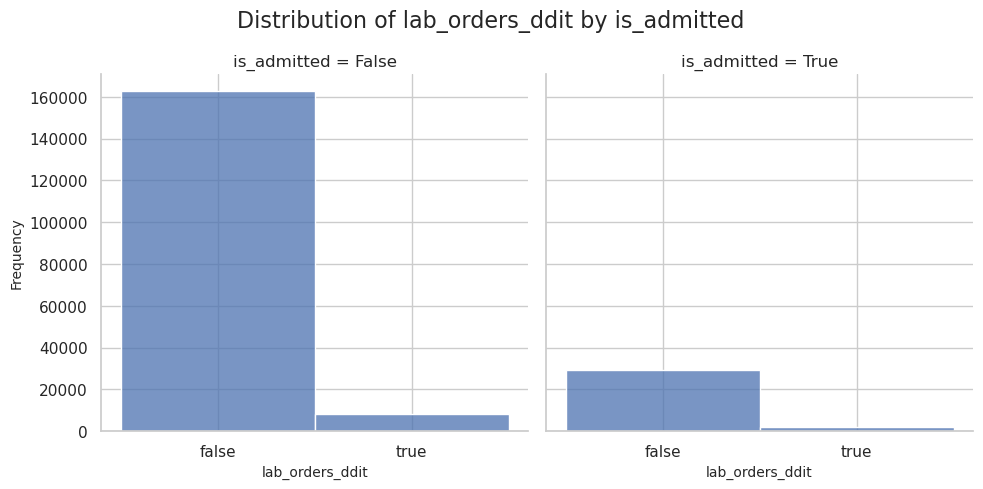

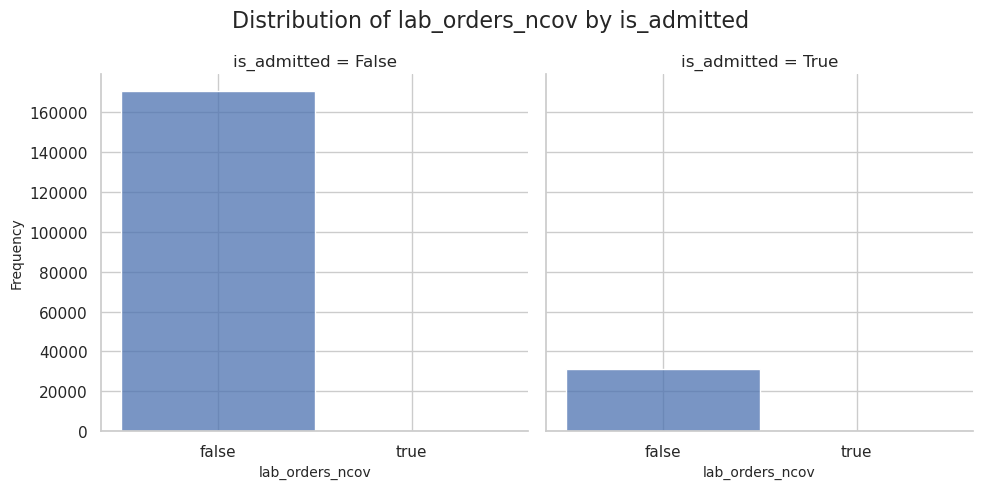

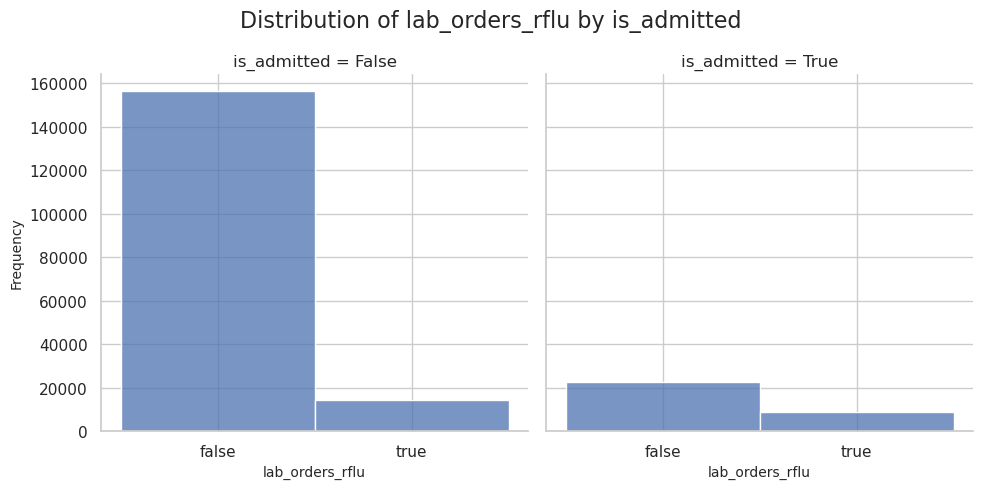

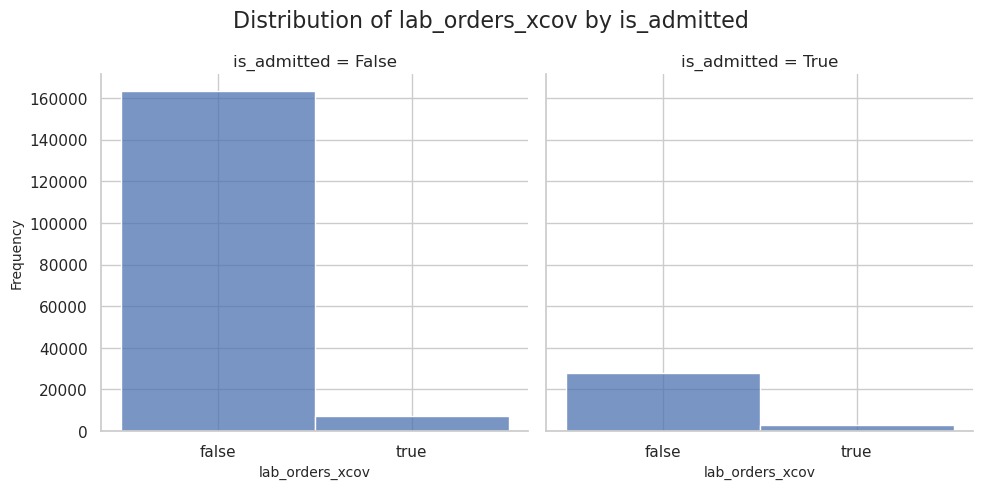

In [115]:
for col_name in [item for item in dict_cols['lab orders and results'] if str(item).startswith('lab') ]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist')

#### Lab results

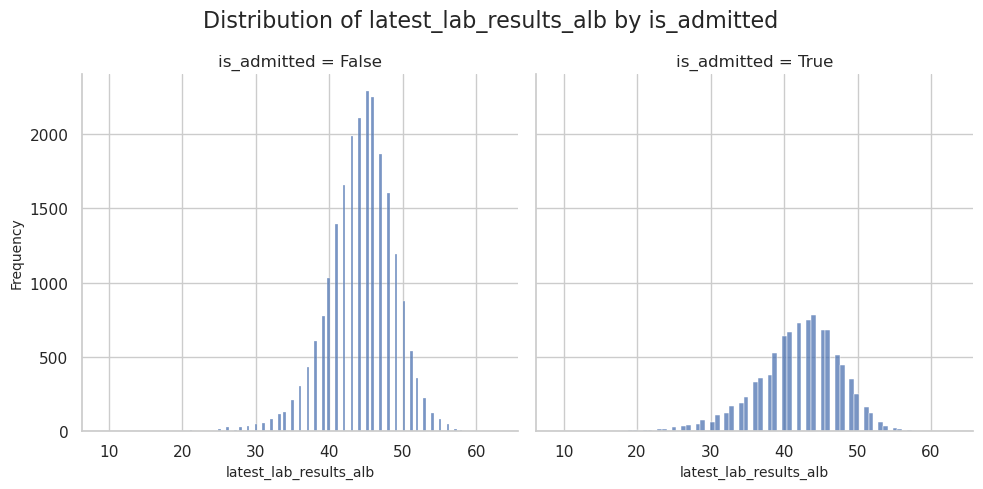

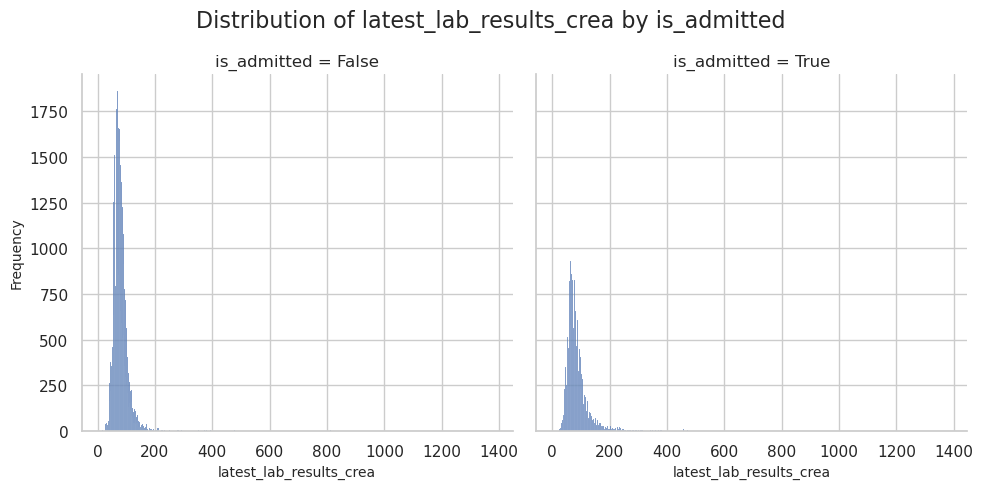

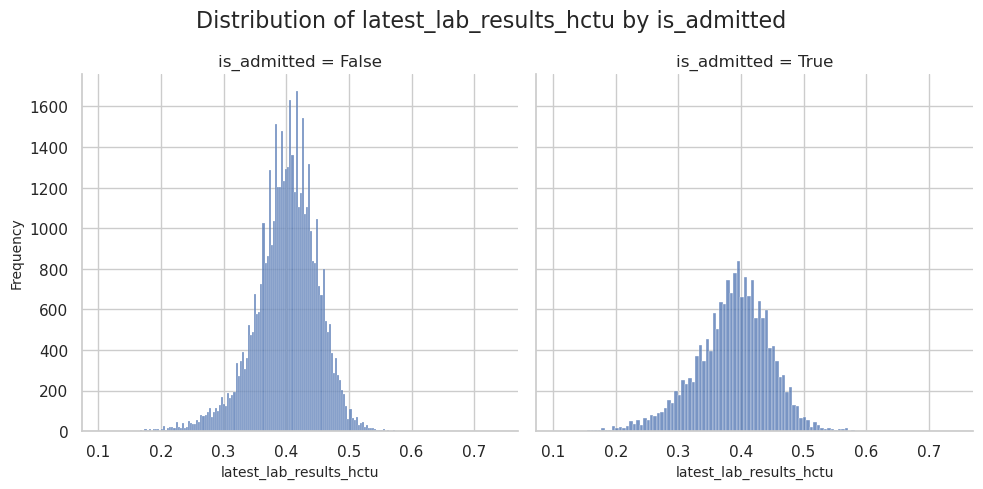

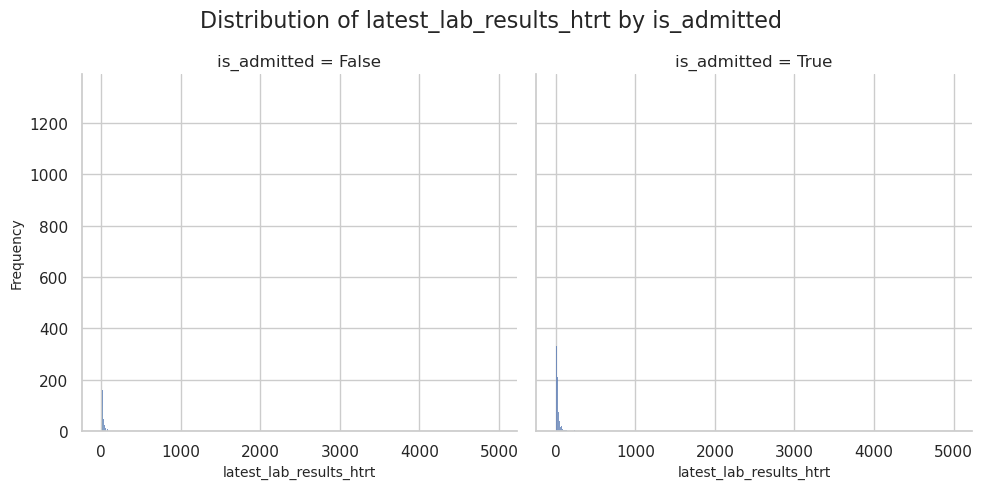

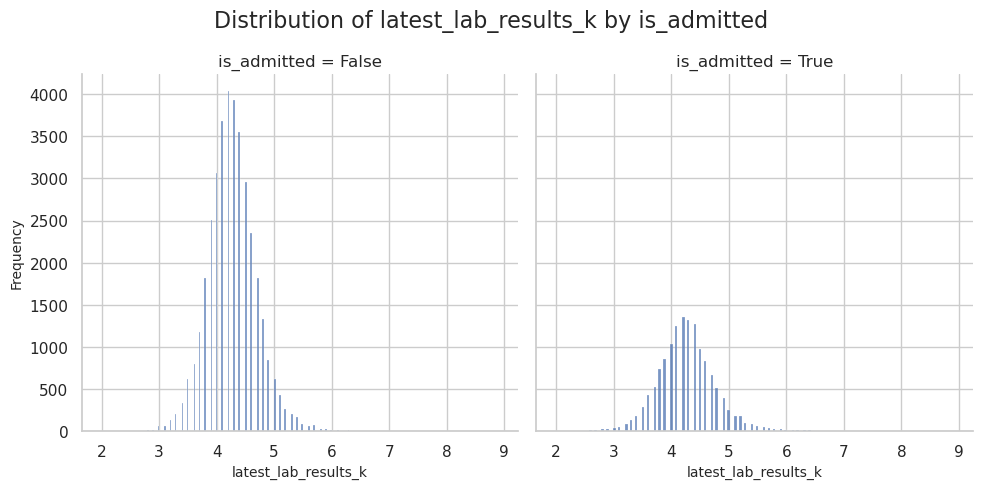

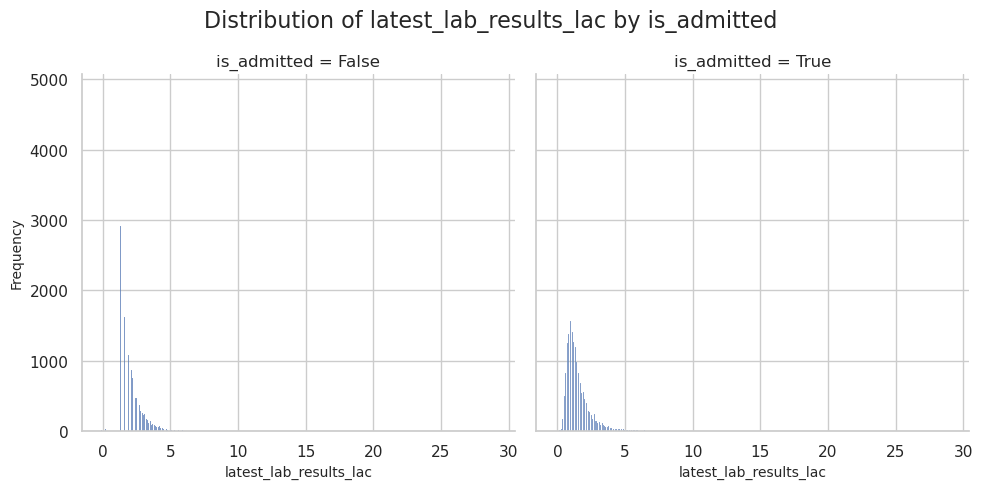

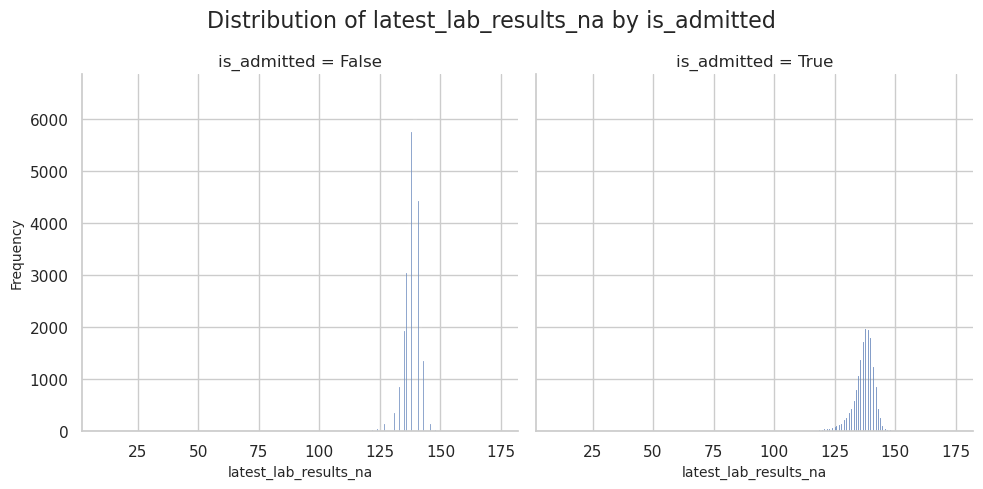

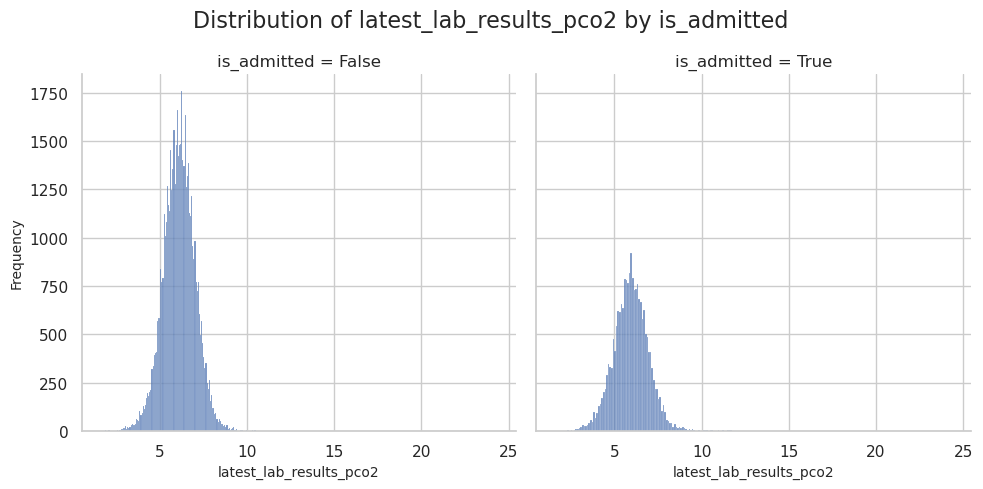

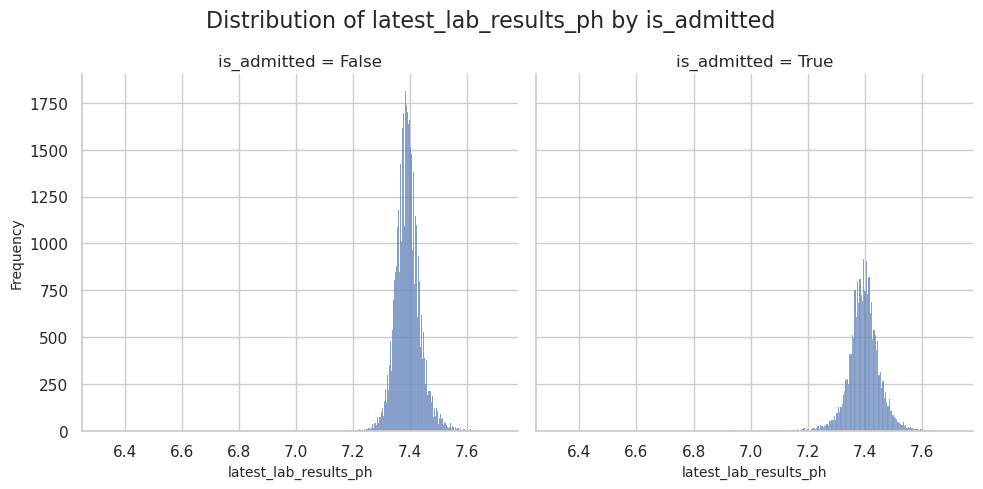

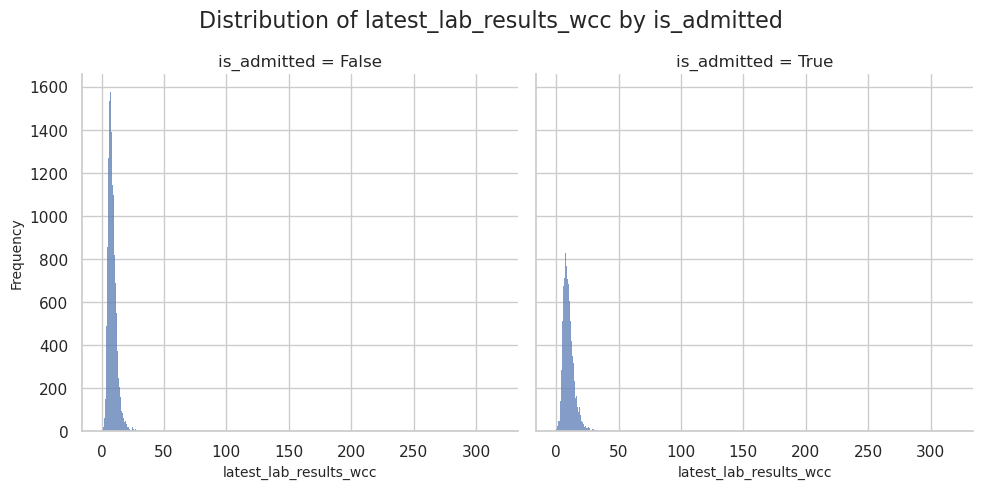

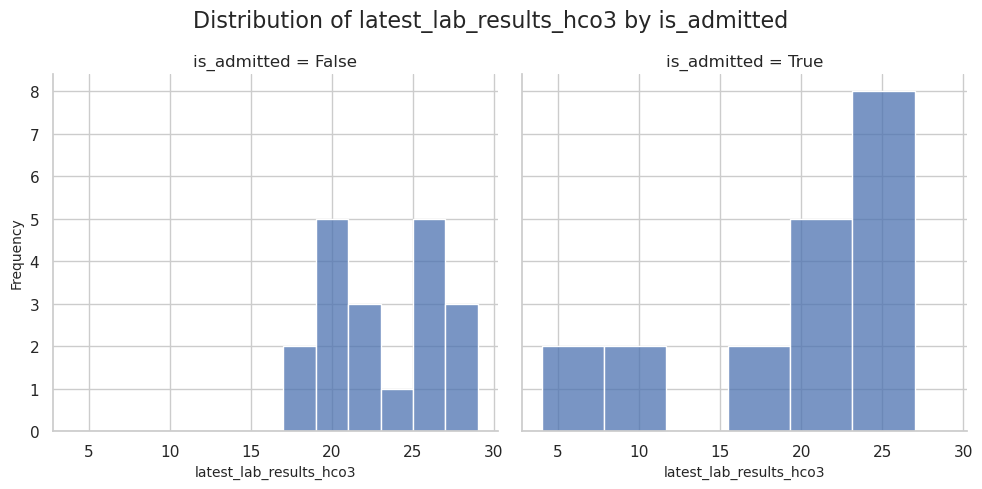

In [116]:
for col_name in [item for item in dict_cols['lab orders and results'] if str(item).startswith('latest') ]:
    plot_distributions(visits, col_name, 'is_admitted', plot_type='hist')

### Consults variables

In [119]:
dict_cols['consults']


['has_consultation', 'consultation_sequence', 'final_sequence', 'specialty']

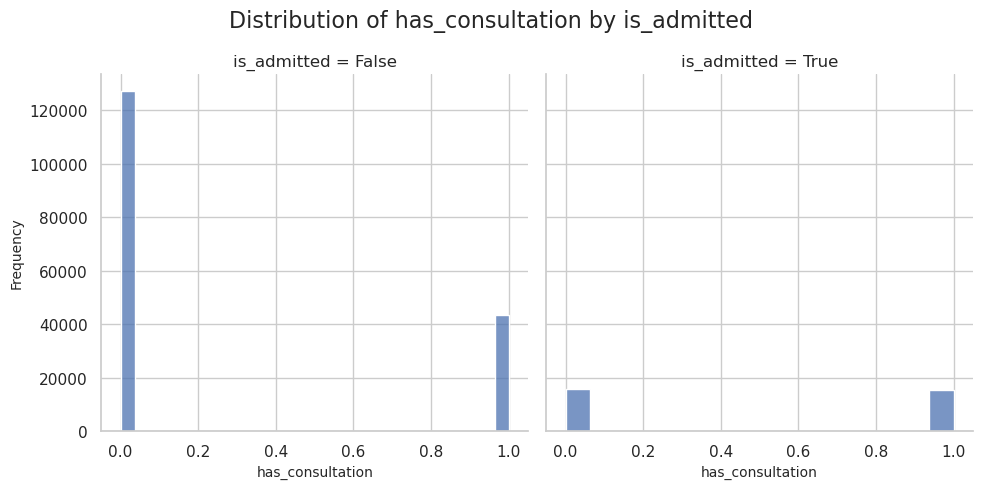

In [42]:
plot_distributions(visits, 'has_consultation', 'is_admitted', plot_type='hist')

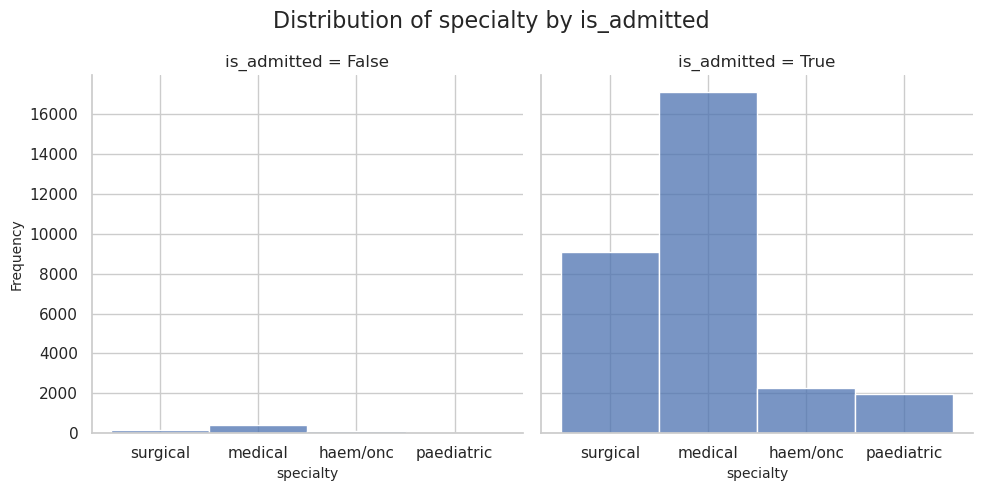

In [37]:
plot_distributions(visits, 'specialty', 'is_admitted', plot_type='hist')

In [38]:
# # Plot code if needed for more detail specialty data

# model_input_path = Path(USER_ROOT / 'ed-predictor' / 'model-input')
# name_mapping = pd.read_csv(str(model_input_path) + '/consults-mapping.csv')

# from matplotlib import pyplot as plt
# spec_summ = visits[visits['consultation_sequence'].map(len) > 0][['consultation_sequence', 'specialty']].explode('consultation_sequence').rename(columns = {'consultation_sequence': 'code'})

# #.reset_index()
# spec_summ = pd.merge(spec_summ, name_mapping, on='code', how='left')
# spec_summ['code_name'] = spec_summ['code'] + ' ' +  spec_summ['name'].str.replace('^Inpatient consult to', '',case=False, regex=True)

# # Group by both 'code_name' and 'specialty' and count occurrences
# frequency = spec_summ.groupby(['code_name', 'specialty']).size().unstack(fill_value=0)

# # Sort the DataFrame by the sum of each row (frequency) in descending order
# frequency_sorted = frequency.sum(axis=1).sort_values(ascending=True)
# frequency = frequency.loc[frequency_sorted.index]

# # Create a figure object with desired size
# fig, ax = plt.subplots(figsize=(20, 20))
# frequency.plot(kind='barh', stacked=True, ax=ax)
# plt.xlabel('Frequency', fontsize=14)
# plt.ylabel('')
# plt.title('Frequency of consultations in ED, mapped to reporting unit on admission', fontsize=18)
# ax.legend(title='Reporting unit', fontsize=14, title_fontsize=16)  # Adjust font sizes here

# # Adjust the spacing between bars on the y-axis
# ax.set_yticks(range(len(frequency.index)))
# ax.set_yticklabels(frequency.index, fontsize=14)
# plt.tight_layout()  # Ensure tight layout to prevent overlapping
# plt.gca().set_aspect('auto')  # Auto-adjust aspect ratio

# plt.show()

## Explore yta dataset

In [45]:
yta.head()

,training_validation_test,arrival_datetime,sex,specialty,is_child
0,train,2030-11-01 17:40:00+00:00,F,surgical,False
1,train,2030-06-13 19:51:00+00:00,F,haem/onc,False
2,train,2030-04-03 17:39:00+00:00,F,haem/onc,False
3,train,2030-04-12 19:00:00+00:00,F,haem/onc,False
4,train,2030-04-05 18:24:00+00:00,F,haem/onc,False


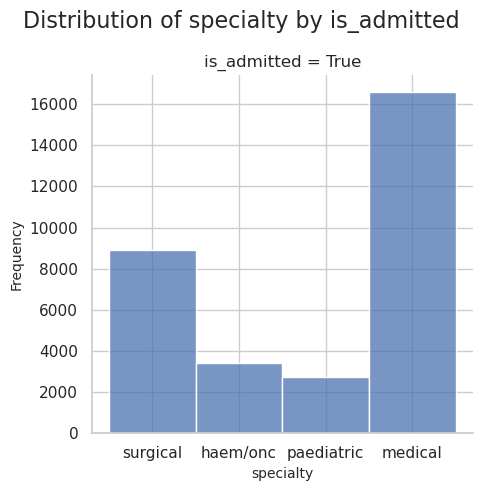

In [50]:
yta['is_admitted'] = True
plot_distributions(yta, 'specialty', 'is_admitted', plot_type='hist')

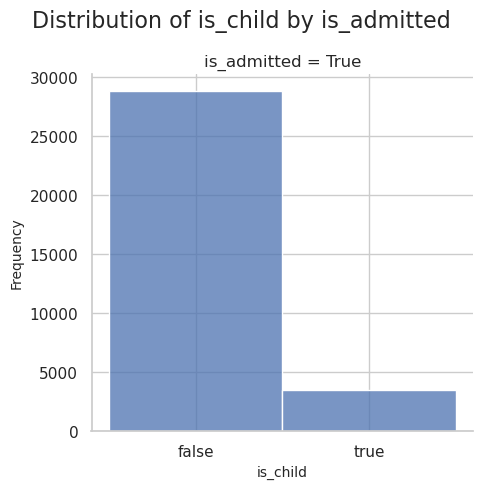

In [51]:
plot_distributions(yta, 'is_child', 'is_admitted', plot_type='hist')